# Cluster Configuration + Imports

In [1]:
from dask.distributed import Client

client = Client("tls://192.168.235.21:8786")
client

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<Client: 'tls://192.168.235.21:8786' processes=58 threads=58, memory=165.94 GiB>

In [56]:
import hist
import time
import json
import dask
import dill 
import operator
import numba
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import normalize
from pprint import pprint
from itertools import combinations, combinations_with_replacement
from collections import defaultdict

import awkward as ak
import dask_awkward as dak
import hist.dask as hda
import vector
vector.register_awkward()

from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import coffea.processor as processor
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

from ScoutingNanoAODSchema import ScoutingNanoAODSchema
client.upload_file("./ScoutingNanoAODSchema.py");
NanoAODSchema.warn_missing_crossrefs = False

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 50
hep.style.use('CMS')

# Coffea Histogram Processor

In [113]:
thresholds = {
        'vtight'  : {'name'  : 'AXO VTight', 'score' : 25000/16},
        'tight'   : {'name'  : 'AXO Tight', 'score' : 20486/16},
        'nominal' : {'name'  : 'AXO Nominal', 'score' : 18580/16},
        'loose'   : {'name'  : 'AXO Loose', 'score' : 17596/16},
        'vloose'  : {'name'  : 'AXO VLoose', 'score' : 15717/16},
}

def multipage(filename, figs=None, dpi=200):
    """Creates a pdf with one page per plot"""
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
        print("No figures handed")
    for fig in figs:
        plt.figure(fig).savefig(pp, format='pdf')
    pp.close()

def getHist(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

def draw_thresholds(ax, threshold_map):
    for th in threshold_map.values():
        ax.axvline(x=th['score'], 
                   label=th['name'], 
                   color=ax._get_lines.get_next_color(),
                   linestyle='--',
                   linewidth=3,
        )

def draw_hist1d(hist_in, ax, label='', rebin=1, norm=False):
    counts, _, bins = hist_in[:,hist.rebin(rebin)].to_numpy()
    if len(counts)>0: # check that there are events to plot
        _counts = counts[0]/(np.sum(counts[0])*np.diff(bins)) if norm else counts[0]
        errs = np.sqrt(counts[0])/(np.sum(counts[0])*np.diff(bins)) if norm else np.sqrt(counts[0])
        _errs = np.where(_counts==0, 0, errs)
        ax.errorbar(x=bins[:-1],y=_counts,yerr=_errs,drawstyle='steps-pre',label=label)
    else:        
        ax.errorbar(x=[],y=[],yerr=[],drawstyle='steps-pre',label=label) # plot nothing
    
def draw_hist2d(hist_in, ax, x_var, y_var, x_rebin=1, y_rebin=1, norm=False):
    cmap = plt.get_cmap('plasma')

    h = hist_in[:,hist.rebin(x_rebin),hist.rebin(y_rebin)]
    w, x, y = h.project(x_var,y_var).to_numpy()
    
    if norm:
        mesh = ax.pcolormesh(x, y, np.where(w.T==0, np.min(w.T[w.T!=0]), w.T),  cmap=cmap)
    else:
        mesh = ax.pcolormesh(x, y, w.T, cmap=cmap)

    return mesh

def find_diObjs(events_obj_coll, isL1, isScouting):
    if isL1:
        rest_mass_dict = {'L1Jet':0, 'L1Mu':0, 'L1EG':0}
        objs = ak.zip(
            {
                "pt": events_obj_coll.pt,
                "eta": events_obj_coll.eta,
                "phi": events_obj_coll.phi,
                "mass": ak.zeros_like(events_obj_coll.pt),
            },
            with_name="PtEtaPhiMLorentzVector",
            behavior=vector.behavior,
        )
        
        diObjs = dak.combinations(objs, 2, fields=["obj1", "obj2"])
        diObj = ak.zip(
            {
                "p4": diObjs.obj1+diObjs.obj2,
            },
        )
        
        diObj["mass"] = np.sqrt(2*diObjs.obj1.pt*diObjs.obj2.pt*(np.cosh(diObjs.obj1.eta-diObjs.obj2.eta)-np.cos(diObjs.obj1.phi-diObjs.obj2.phi)))
    elif isScouting:
        rest_mass_dict = {'ScoutingJet':0, 'ScoutingMuonVtx':0, 'ScoutingElectron':0}
        try:
            objs = ak.zip(
                {
                    "pt": events_obj_coll.pt,
                    "eta": events_obj_coll.eta,
                    "phi": events_obj_coll.phi,
                    "mass": events_obj_coll.mass,
                },
                with_name="PtEtaPhiMLorentzVector",
                behavior=vector.behavior,
            )
        except:
            objs = ak.zip(
                {
                    "pt": events_obj_coll.pt,
                    "eta": events_obj_coll.eta,
                    "phi": events_obj_coll.phi,
                    "mass": events_obj_coll.m,
                },
                with_name="PtEtaPhiMLorentzVector",
                behavior=vector.behavior,
            )
            
        diObjs = dak.combinations(objs, 2, fields=["obj1", "obj2"])
        diObj = ak.zip(
            {
                "p4": diObjs.obj1+diObjs.obj2,
            },
        )
        
        diObj["mass"] = np.sqrt(2*diObjs.obj1.pt*diObjs.obj2.pt*(np.cosh(diObjs.obj1.eta-diObjs.obj2.eta)-np.cos(diObjs.obj1.phi-diObjs.obj2.phi)))
    
    else:
        objs = ak.zip({ 
            k: getattr(events_obj_coll, k) for k in ["x", "y", "z", "t"] }, 
            with_name="LorentzVector", 
            behavior=events_obj_coll.behavior, 
        )

        diObj = dak.combinations(objs, 2, fields=["obj1", "obj2"])
        diObj["p4"] = diObj.obj1 + diObj.obj2
        diObj["mass"] = diObj.p4.mass

    return diObj


    
class MakeAXOHists (processor.ProcessorABC):
    def __init__(self, trigger_paths=[], has_scores=True, is_scouting=False, extra_cut='', thresholds=None, object_dict=None):
        if is_scouting:
            the_object_dict =  {'ScoutingJet' :      {'cut' : [('pt', 30.)], 'label' : 'j'},
                                'ScoutingElectron' : {'cut' : [('pt', 10)], 'label' : 'e'},
                                'ScoutingMuonNoVtx' :     {'cut' : [('pt', 3)], 'label' : '\mu'},
                                'ScoutingPhoton' :     {'cut' : [('pt', 10)], 'label' : '\gamma'},
                                'L1Jet' :    {'cut' : [('pt', 0.1)], 'label' : 'L1j'},
                                'L1EG' :     {'cut' : [('pt', 0.1)], 'label' : 'L1e'},
                                'L1Mu' :     {'cut' : [('pt', 0.1)], 'label' : 'L1\mu'}
                               }
        else:
            the_object_dict =  {'Jet' :      {'cut' : [('pt', 30.)], 'label' : 'j'},
                                'Electron' : {'cut' : [('pt', 10)], 'label' : 'e'},
                                'Muon' :     {'cut' : [('pt', 3)], 'label' : '\mu'},
                                'L1Jet' :    {'cut' : [('pt', 0.1)], 'label' : 'L1j'},
                                'L1EG' :     {'cut' : [('pt', 0.1)], 'label' : 'L1e'},
                                'L1Mu' :     {'cut' : [('pt', 0.1)], 'label' : 'L1\mu'}
                               }      
        self.run_dict = {
            'thresholds' : thresholds if thresholds is not None else {
                'AXOVTight_EMU'  : {'name'  : 'AXO VTight', 'score' : 25000/16},
                'AXOTight_EMU'   : {'name'  : 'AXO Tight', 'score' : 20486/16},
                'AXONominal_EMU' : {'name'  : 'AXO Nominal', 'score' : 18580/16},
                'AXOLoose_EMU'   : {'name'  : 'AXO Loose', 'score' : 17596/16},
                'AXOVLoose_EMU'  : {'name'  : 'AXO VLoose', 'score' : 15717/16},
            },
            'objects' : object_dict if object_dict is not None else the_object_dict
        }

        self.sorted_keys = sorted(self.run_dict['thresholds'],key=lambda i: self.run_dict['thresholds'][i]['score'])
        self.trigger_paths = trigger_paths
        self.has_scores = has_scores
        self.is_scouting = is_scouting
        self.extra_cut = extra_cut
        
        self.dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        self.score_axis = hist.axis.Regular(100, 0, 4000, name="score", label='Anomaly Score')
        self.mult_axis = hist.axis.Regular(200,0,201, name="mult", label=r'$N_{obj}$')
        self.pt_axis = hist.axis.Regular(500,0,5000, name="pt", label=r"$p_{T}$ [GeV]")
        self.eta_axis = hist.axis.Regular(150,-5,5, name="eta", label=r"$\eta$")
        self.phi_axis = hist.axis.Regular(30,-4,4, name="phi", label=r"$\phi$")
        self.met_axis = hist.axis.Regular(250,0,2500, name="met", label=r"$p^{miss}_{T} [GeV]$")
        self.ht_axis = hist.axis.Regular(100,0,2000, name="ht", label=r"$H_{T}$ [GeV]")
        self.minv_axis = hist.axis.Regular(3000,0,3001, name="minv", label=r"$m_{obj_{1},obj_{2}}$ [GeV]")

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = defaultdict(int)
        cutflow['start'] = ak.num(events.event, axis=0)
        hist_dict = {}
        
        # Saturated-Jets event cut
        events = events[dak.all(events.L1Jet.pt<1000,axis=1)]
        # Saturated-MET event cut
        events = events[dak.flatten(events.L1EtSum.pt[(events.L1EtSum.etSumType==2) & (events.L1EtSum.bx==0)])<1040]
 
        # Trigger requirement
        for trigger_path in self.trigger_paths: # loop over trigger paths
            events_trig = None
            if trigger_path == "all":
                events_trig = events
            else:
                trig_br = getattr(events,trigger_path.split('_')[0])
                trig_path = '_'.join(trigger_path.split('_')[1:])
                events_trig = events[getattr(trig_br,trig_path)] # select events passing this trigger
            #cutflow[trigger_path] = ak.count(events_trig.event)  
            cutflow[trigger_path] = ak.num(events_trig.event, axis=0)

            # Get scalar branches
            l1_etsums = events_trig.L1EtSum
            l1_ht = l1_etsums[(events_trig.L1EtSum.etSumType==1) & (events_trig.L1EtSum.bx==0)]
            l1_met = l1_etsums[(events_trig.L1EtSum.etSumType==2) & (events_trig.L1EtSum.bx==0)]
            l1_total_mult = ak.num(events_trig.L1Jet.bx == 0) + ak.num(events_trig.L1Mu.bx == 0) + ak.num(events_trig.L1EG.bx ==0)
            l1_total_pt = (ak.sum(events_trig.L1Jet.pt[events_trig.L1Jet.bx == 0],axis=1) 
                           + ak.sum(events_trig.L1Mu.pt[events_trig.L1Mu.bx == 0],axis=1) 
                           + ak.sum(events_trig.L1EG.pt[events_trig.L1EG.bx ==0],axis=1))

            scouting_ht = ak.sum(events_trig.ScoutingJet.pt,axis=1)
            scouting_met = events_trig.ScoutingMET.pt
            scouting_total_mult = ak.num(events_trig.ScoutingJet) + ak.num(events_trig.ScoutingElectron) + ak.num(events_trig.ScoutingMuonNoVtx)
            scouting_total_pt = ak.sum(events_trig.ScoutingJet.pt,axis=1) + ak.sum(events_trig.ScoutingElectron.pt,axis=1) + ak.sum(events_trig.ScoutingMuonNoVtx.pt,axis=1)
            scouting_npv = ak.num(events_trig.ScoutingPrimaryVertex)
            scouting_bjet = ak.num(events_trig.ScoutingPrimaryVertex)#ak.flatten(events_trig.ScoutingJet.particleNet_prob_b)

            # Fill 1D scalar histograms - w/trigger
            if self.has_scores:
                axo = events_trig.axol1tl
                h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
                h_score.fill(dataset=dataset, score=axo.score_bx0)
                hist_dict[f'anomaly_score_{trigger_path}'] = h_score

                h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
                h_score.fill(dataset=dataset, score=axo.score_bx0_unpf)
                hist_dict[f'anomaly_score_unpf_{trigger_path}'] = h_score

                h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
                h_score.fill(dataset=dataset, score=axo.score_bx0_unpf_firstbx)
                hist_dict[f'anomaly_score_unpf_firstbx_{trigger_path}'] = h_score

                # Fill 2D scalar histograms - w/trigger
                h_score_l1ht = hda.hist.Hist(self.dataset_axis, self.score_axis, self.ht_axis, storage="weight", label="nEvents")
                h_score_l1ht.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_ht.pt)[0]), ht=ak.flatten(l1_ht.pt))
                hist_dict[f'anomaly_score_l1ht_{trigger_path}'] = h_score_l1ht                              

                h_score_l1met = hda.hist.Hist(self.dataset_axis, self.score_axis, self.met_axis, storage="weight", label="nEvents")
                h_score_l1met.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_met.pt)[0]), met=ak.flatten(l1_met.pt))
                hist_dict[f'anomaly_score_l1met_{trigger_path}'] = h_score_l1met

                h_score_total_mult = hda.hist.Hist(self.dataset_axis, self.score_axis, self.mult_axis, storage="weight", label="nEvents")
                h_score_total_mult.fill(dataset=dataset, score=axo.score_bx0, mult=l1_total_mult)
                hist_dict[f'anomaly_score_total_mult_{trigger_path}'] = h_score_total_mult

                h_score_total_pt = hda.hist.Hist(self.dataset_axis, self.score_axis, self.pt_axis, storage="weight", label="nEvents")
                h_score_total_pt.fill(dataset=dataset, score=axo.score_bx0, pt=l1_total_pt)
                hist_dict[f'anomaly_score_total_pt_{trigger_path}'] = h_score_total_pt


            h_l1ht = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
            h_l1ht.fill(dataset=dataset, ht=ak.flatten(l1_ht.pt))
            hist_dict[f'l1ht_{trigger_path}'] = h_l1ht  

            h_l1met = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
            h_l1met.fill(dataset=dataset, met=ak.flatten(l1_met.pt))
            hist_dict[f'l1met_{trigger_path}'] = h_l1met

            h_total_l1mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
            h_total_l1mult.fill(dataset=dataset, mult=l1_total_mult)
            hist_dict[f'total_l1mult_{trigger_path}'] = h_total_l1mult

            h_total_l1pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
            h_total_l1pt.fill(dataset=dataset, pt=l1_total_pt)
            hist_dict[f'total_l1pt_{trigger_path}'] = h_total_l1pt

            # Fill 1D scalar histograms Scouting objects
            h_scoutinght = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
            h_scoutinght.fill(dataset=dataset, ht=scouting_ht)
            hist_dict[f'scoutinght_{trigger_path}'] = h_scoutinght                              

            h_scoutingmet = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
            h_scoutingmet.fill(dataset=dataset, met=scouting_met)
            hist_dict[f'scoutingmet_{trigger_path}'] = h_scoutingmet

            h_total_scoutingmult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
            h_total_scoutingmult.fill(dataset=dataset, mult=scouting_total_mult)
            hist_dict[f'total_scoutingmult_{trigger_path}'] = h_total_scoutingmult

            h_total_scoutingpt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
            h_total_scoutingpt.fill(dataset=dataset, pt=scouting_total_pt)
            hist_dict[f'total_scoutingpt_{trigger_path}'] = h_total_scoutingpt
            
            h_scouting_npv = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
            h_scouting_npv.fill(dataset=dataset, mult=scouting_npv)
            hist_dict[f'scoutingnpv_{trigger_path}'] = h_scouting_npv

            h_scouting_bjet = hda.hist.Hist(self.dataset_axis, self.phi_axis, storage="weight", label="nEvents")
            h_scouting_bjet.fill(dataset=dataset, phi=scouting_bjet)
            hist_dict[f'scoutingbjet_{trigger_path}'] = h_scouting_bjet

            # Process object collections - w/trigger
            for obj,obj_dict in self.run_dict['objects'].items():
                cut_list = obj_dict['cut']
                label = obj_dict['label']
                isL1Obj = 'L1' in obj
                isScoutingObj = 'Scouting' in obj
                br = getattr(events_trig, obj)

                # Filter only L1 Objects from BX==0
                if isL1Obj:
                    br = br[br.bx==0]

                # Apply list of cuts to relevant branches
                for var, cut in cut_list:
                    mask = (getattr(br,var) > cut)
                    br = br[mask]        

                # Build di-object candidate
                objs = br[ak.argsort(br.pt, axis=1)]
                diObj = find_diObjs(objs[:,0:2], isL1Obj,isScoutingObj)

                # Fill 1D histograms - w/trigger
                h_mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
                h_mult.fill(dataset=dataset, mult=dak.num(br))
                hist_dict[f'n_{obj}_{trigger_path}'] = h_mult

                h_pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                h_pt.fill(dataset=dataset, pt=dak.flatten(br.pt))
                hist_dict[f'pt_{obj}_{trigger_path}'] = h_pt

                h_eta = hda.hist.Hist(self.dataset_axis, self.eta_axis, storage="weight", label="nEvents")
                h_eta.fill(dataset=dataset, eta=dak.flatten(br.eta))
                hist_dict[f'eta_{obj}_{trigger_path}'] = h_eta

                h_phi = hda.hist.Hist(self.dataset_axis, self.phi_axis, storage="weight", label="nEvents")
                h_phi.fill(dataset=dataset, phi=dak.flatten(br.phi))
                hist_dict[f'phi_{obj}_{trigger_path}'] = h_phi

                h_minv = hda.hist.Hist(self.dataset_axis, self.minv_axis, storage="weight", label="nEvents")
                h_minv.fill(dataset=dataset, minv=dak.flatten(diObj.mass))
                hist_dict[f'm{obj}{obj}_{trigger_path}'] = h_minv

                # Fill 2D histograms - w/trigger
                if self.has_scores:
                    h_score_mult = hda.hist.Hist(self.dataset_axis, self.score_axis, self.mult_axis, storage="weight", label="nEvents")
                    h_score_mult.fill(dataset=dataset, score=axo.score_bx0, mult=dak.num(br))
                    hist_dict[f'anomaly_score_n_{obj}_{trigger_path}'] = h_score_mult

                    h_score_pt = hda.hist.Hist(self.dataset_axis, self.score_axis, self.pt_axis, storage="weight", label="nEvents")
                    h_score_pt.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.pt)[0]), pt=dak.flatten(br.pt))
                    hist_dict[f'anomaly_score_pt_{obj}_{trigger_path}'] = h_score_pt

                    h_score_eta = hda.hist.Hist(self.dataset_axis, self.score_axis, self.eta_axis, storage="weight", label="nEvents")
                    h_score_eta.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.eta)[0]), eta=dak.flatten(br.eta))
                    hist_dict[f'anomaly_score_eta_{obj}_{trigger_path}'] = h_score_eta

                    h_score_phi = hda.hist.Hist(self.dataset_axis, self.score_axis, self.phi_axis, storage="weight", label="nEvents")
                    h_score_phi.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.phi)[0]), phi=dak.flatten(br.phi))
                    hist_dict[f'anomaly_score_phi_{obj}_{trigger_path}'] = h_score_phi

                    h_score_minv = hda.hist.Hist(self.dataset_axis, self.score_axis, self.minv_axis, storage="weight", label="nEvents")
                    h_score_minv.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,diObj.mass)[0]), minv=dak.flatten(diObj.mass))
                    hist_dict[f'anomaly_score_m{obj}{obj}_{trigger_path}'] = h_score_minv

                h_eta_phi = hda.hist.Hist(self.dataset_axis, self.eta_axis, self.phi_axis, storage="weight", label="nEvents")
                h_eta_phi.fill(dataset=dataset, eta=dak.flatten(br.eta), phi=dak.flatten(br.phi))
                hist_dict[f'eta_phi_{obj}_{trigger_path}'] = h_eta_phi   

                h_mult_eta = hda.hist.Hist(self.dataset_axis, self.mult_axis, self.eta_axis, storage="weight", label="nEvents")
                h_mult_eta.fill(dataset=dataset, mult=dak.flatten(ak.broadcast_arrays(dak.num(br),br.eta)[0]), eta=dak.flatten(br.eta))
                hist_dict[f'n_eta_{obj}_{trigger_path}'] = h_mult_eta

                h_eta_pt = hda.hist.Hist(self.dataset_axis, self.eta_axis, self.pt_axis, storage="weight", label="nEvents")
                h_eta_pt.fill(dataset=dataset, eta=dak.flatten(br.eta), pt=dak.flatten(br.pt))
                hist_dict[f'eta_pt_{obj}'] = h_eta_pt
        
        # At least two opposite sign muons
        events = events[(ak.num(events.ScoutingMuonNoVtx,axis=1)>=2) & (ak.sum(events.ScoutingMuonNoVtx.charge[:,0:2],axis=1)==0)]
        cutflow["dimuon"+trigger_path] = ak.num(events.event, axis=0)
        
        obj = "ScoutingMuonNoVtx"
        obj_dict = self.run_dict['objects'][obj]

        for trigger_path in self.trigger_paths: # loop over trigger paths
            events_trig = None

            if trigger_path == "all":
                events_trig = events
            else:
                trig_br = getattr(events,trigger_path.split('_')[0])
                trig_path = '_'.join(trigger_path.split('_')[1:])
                events_trig = events[getattr(trig_br,trig_path)] # select events passing this trigger
            cutflow["dimuon"+trigger_path] = ak.num(events_trig.event, axis=0)

            cut_list = obj_dict['cut']
            label = obj_dict['label']
            isL1Obj = 'L1' in obj
            isScoutingObj = 'Scouting' in obj
            br = getattr(events_trig, obj)


            # Apply list of cuts to relevant branches
            for var, cut in cut_list:
                mask = (getattr(br,var) > cut)
                br = br[mask]        

            # Build di-object candidate
            objs = br[ak.argsort(br.pt, axis=1)]
            diObj = find_diObjs(objs[:,0:2], isL1Obj,isScoutingObj)

            h_minv = hda.hist.Hist(self.dataset_axis, self.minv_axis, storage="weight", label="nEvents")
            h_minv.fill(dataset=dataset, minv=dak.flatten(diObj.mass))
            hist_dict[f'dimuon_m{obj}{obj}_{trigger_path}'] = h_minv
                
        
        return {
            'cutflow' : cutflow,
            'hists'   : hist_dict,
            'trigger' : self.trigger_paths if len(self.trigger_paths)>0 else None
        }

    def postprocess(self, accumulator):
        return accumulator

class PureEvents(processor.ProcessorABC):
    def __init__(self, trigger_path, all_seeds):
        self.trigger_path = trigger_path
        self.l1_seeds = all_seeds
        
        if self.trigger_path in self.l1_seeds:
            self.l1_seeds.remove(self.l1_seeds)

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = defaultdict(int)
        cutflow['start'] = ak.num(events.event, axis=0)
         
        hlt_trigs = events.HLT
        pure_path = getattr(hlt_trigs,self.trigger_path.lstrip('HLT').lstrip('_'))
        cutflow['AXO_total'] = ak.count(events[pure_path==1].event)

        l1_trigs = events.L1
        for seed in [s.lstrip('L1').lstrip('_') for s in self.l1_seeds]:
            trig_flag = getattr(l1_trigs,seed)
            events = events[trig_flag==0]
            l1_trigs = events.L1
        
        cutflow['not_firing_L1s'] = ak.count(events.event)
        
        hlt_trigs = events.HLT
        pure_path = getattr(hlt_trigs,self.trigger_path.lstrip('HLT').lstrip('_'))
        events = events[pure_path==1]
        cutflow['AXO_pure'] = ak.count(events.event)

        metadata = {
            'run' : events.run,
            'luminosityBlock' :  events.luminosityBlock,
            'event' : events.event,
        }
        return {
            'dataset' : dataset,
            'cutflow' : cutflow,
            'pure_event_metadata' : metadata,
        }

    def postprocess(self, accumulator):
        return accumulator
    


# Configure & Process Datasets

## Preprocess Input Files

In [133]:
url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/official/L1Menu_Collisions2024_v1_1_0/PrescaleTable/L1Menu_Collisions2024_v1_1_0.csv"
df = pd.read_csv(url)
active_cols = [x for x in df.columns.to_list() if x not in ['Index','Name','Emergency']]
all_L1_seeds = df['Name'].to_numpy()
active_l1_seeds = df[(df[active_cols]>0).any(axis=1)]['Name'].to_numpy()
fulllumi_L1_seeds = df[df['2p0E34']>0]['Name'].to_numpy()


dataset_test = {
    'JetMET_2024D_wScores' : {
        'files' : {
            "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_5.root" : "Events"
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_6.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_7.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_8.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_9.root" : "Events"        
        }
    }
}

dataset_test_runnable, dataset_test_updated = preprocess(
    dataset_test,
    align_clusters=False,
    step_size=10_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)


with open('2024D_data_filelist.json') as json_file:
    dataset = json.load(json_file)

#dataset_skimmed = {k:v for k,v in dataset.items() if k in ['Scouting_Run380310']}
#dataset_skimmed = {k:v for k,v in dataset.items() if k in ['Scouting_Run380360_test']}
dataset_skimmed = {k:v for k,v in dataset.items() if k in ['Scouting_Golden_test']}
#dataset_skimmed = {k:v for k,v in dataset.items() if k in ['Scouting_380470']} #giant
#dataset_skimmed = {k:v for k,v in dataset.items() if k in ['JetMET_Run380310_test']}
#dataset_skimmed = {k:v for k,v in dataset.items() if k in ['JetMET_Run380310_test_wScores']}
#dataset_skimmed = {k:v for k,v in dataset.items() if k in ['JetMET_Run380310_wScores']}
# dataset_skimmed = {k:v for k,v in dataset.items() if k in ['JetMET_Run380310_wScores', 'JetMET_Run380348_wScores', 'JetMET_Run380349_wScores']}

dataset_runnable, dataset_updated = preprocess(
    dataset_skimmed,
    align_clusters=False,
    step_size=100_000, #default
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

## Run Histogram Producer

In [134]:
#histpath = ['JetMET_Run380310_test_wScores','hists']
#histpath = ['JetMET_Run380310_test','hists']
#histpath = ['Scouting_Run380470','hists']
histpath = ['Scouting_Golden_test','hists']
#triggers = ['HLT_L1AXOVTight'] 
triggers = ["all",'DST_PFScouting_JetHT','DST_PFScouting_DoubleMuon','DST_PFScouting_AXONominal','DST_PFScouting_AXOTight','HLT_L1AXOVTight']
has_scores = True if 'wScores' in histpath[0] else False
is_scouting = True if 'Scouting' in histpath[0] else False
if is_scouting:
    reco_objects = ["ScoutingJet","ScoutingElectron","ScoutingMuonNoVtx","ScoutingPhoton"]
else:
    reco_objects = ["Jet","Electron","Muon"]

triggers = ['DST_PFScouting_JetHT','DST_PFScouting_DoubleMuon','DST_PFScouting_AXONominal','DST_PFScouting_AXOTight','HLT_L1AXOVTight']
trigger_names = {'DST_PFScouting_JetHT':"JetHT",
                      'DST_PFScouting_DoubleMuon':"Double Muon",
                      'DST_PFScouting_AXONominal':"AXO Nominal",
                      'DST_PFScouting_AXOTight':"AXO Tight",
                      'HLT_L1AXOVTight':"AXO Very Tight"}


In [135]:
tstart = time.time()
to_compute = apply_to_fileset(
                MakeAXOHists(trigger_paths=triggers, 
                             has_scores=has_scores, 
                             is_scouting=is_scouting),
                max_chunks(dataset_runnable, 300000),
                # max_chunks(dataset_runnable, 1), #quick testing
                schemaclass=ScoutingNanoAODSchema,
                uproot_options={"allow_read_errors_with_report": (OSError, TypeError, KeyError)}
            )
(hist_result,) = dask.compute(to_compute)
print(f'{time.time()-tstart:.1f}s to process')
hist_result = hist_result[0]

161.8s to process


In [ ]:
# Save file 
# with open('hist_result_'+histpath[0]+'.pkl', 'wb') as file:

#     # dump information to that file
#     dill.dump(hist_result, file)

In [99]:
# Open existing pkl file
# with open('hist_result_Scouting_380470.pkl', 'rb') as file:
#      hist_result = dill.load(file)
#histpath = ['Scouting_Run380470','hists']

# Plotting

## Score Plots

In [80]:
#histpath = ['JetMET_Run380310_test_wScores','hists']
#triggers = ['HLT_L1AXOVTight']

if has_scores:
    fig, ax = plt.subplots(figsize=(14,10))
    norm = False
    hep.cms.label('Preliminary', data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)

    draw_hist1d(getHist(hist_result, histpath+['anomaly_score']), ax, label='All Events', rebin=1, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+['anomaly_score_'+trigger]), ax, label=trigger, rebin=1, norm=norm)
        draw_hist1d(getHist(hist_result, histpath+['anomaly_score_unpf_'+trigger]), ax, label=trigger+' unPF [trig. rules]', rebin=1, norm=norm)
        draw_hist1d(getHist(hist_result, histpath+['anomaly_score_unpf_firstbx_'+trigger]), ax, label=trigger+' unPF [first bx]', rebin=1, norm=norm)

    draw_thresholds(ax, thresholds)

    # ax.set_ylim(1E-8, .1)
    ax.set_xlim(0, 3000)
    ax.set_yscale('log')
    ax.set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax.legend(frameon=True, fontsize=16);
    multipage("plots/"+histpath[0]+"_1D_scores.pdf", figs=plt.get_fignums(), dpi=200)

## Event-Level Kinematic Plots

### L1 Objects

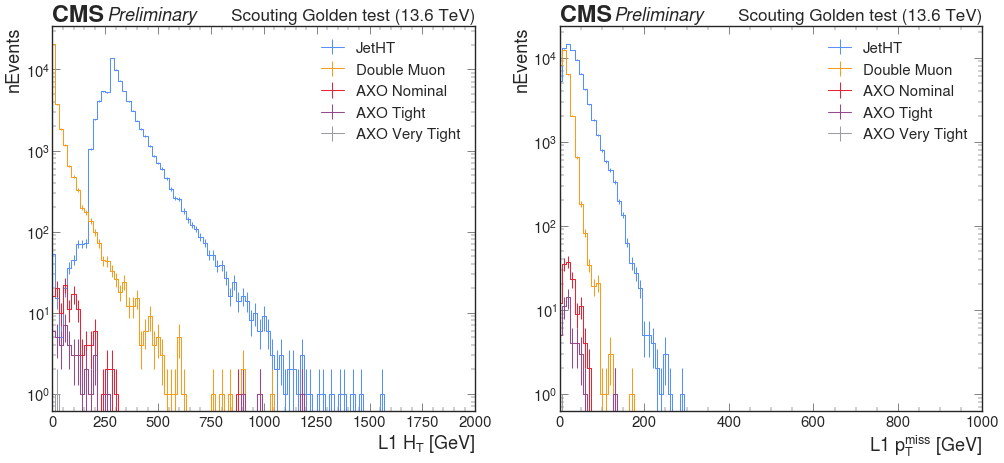

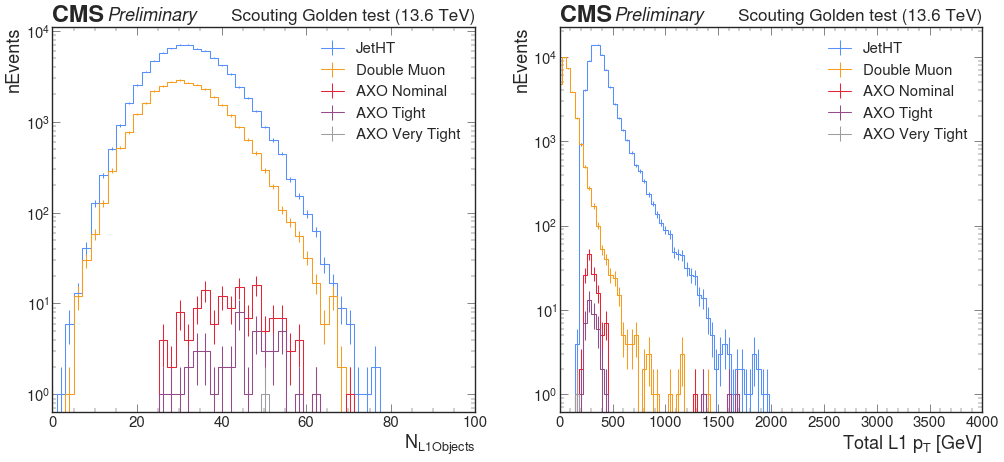

In [136]:
fig, ax = plt.subplots(1, 2, figsize=(24, 10))

# HT
get_name = lambda suf=None: f'l1ht_{suf}' if suf else f'l1ht'
norm = False#

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[0], label='All Events', rebin=1, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[0], label=trigger_names[trigger], rebin=1, norm=norm)

hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[0].set_xlim(0,2000)
ax[0].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[0].set_xlabel(r'L1 $H_{T}$ [GeV]', loc='right')
ax[0].set_yscale('log')
ax[0].legend();

# MET
get_name = lambda suf=None: f'l1met_{suf}' if suf else f'l1met'
norm = False

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[1], label='All Events', rebin=4, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[1], label=trigger_names[trigger], rebin=1, norm=norm)
            
hep.cms.label('Preliminary', ax=ax[1], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[1].set_xlim(0,1000)
ax[1].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[1].set_xlabel(r'L1 $p^{miss}_{T}$ [GeV]', loc='right')
ax[1].set_yscale('log')
ax[1].legend();

fig, ax = plt.subplots(1, 2, figsize=(24, 10))

# Total Object Multiplicity
get_name = lambda suf=None: f'total_l1mult_{suf}' if suf else f'total_l1mult'
norm = False

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[0], label='All Events', rebin=10, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[0], label=trigger_names[trigger], rebin=2, norm=norm)

hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[0].set_xlim(0,100)
ax[0].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[0].set_xlabel(r'$N_{L1 Objects}$', loc='right')
ax[0].set_yscale('log')
ax[0].legend();

# Total Object Pt
get_name = lambda suf=None: f'total_l1pt_{suf}' if suf else f'total_l1pt'
norm = False

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[1], label='All Events', rebin=4, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[1], label=trigger_names[trigger], rebin=4, norm=norm)
            
hep.cms.label('Preliminary', ax=ax[1], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[1].set_xlim(0,4000)
ax[1].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[1].set_xlabel(r'Total L1 $p_{T}$ [GeV]', loc='right')
ax[1].set_yscale('log')
ax[1].legend();



multipage("plots/"+histpath[0]+"_1D_L1.pdf", figs=plt.get_fignums(), dpi=200)

In [137]:
#sorted(hist_result["Scouting_Golden_test"]['hists'].keys())

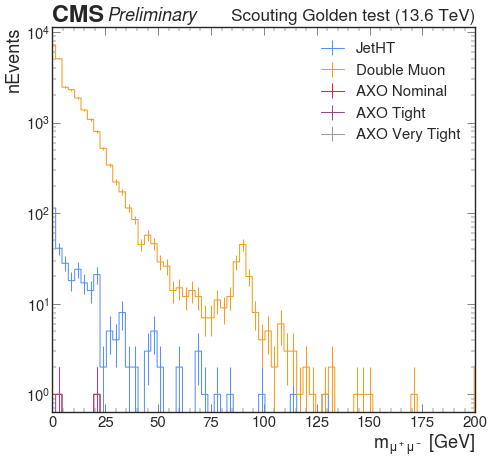

In [138]:

fig, ax = plt.subplots(1, 2, figsize=(24, 10))
get_name = lambda suf=None: f'dimuon_mScoutingMuonNoVtxScoutingMuonNoVtx_{suf}' if suf else f'dimuon_mScoutingMuonNoVtxScoutingMuonNoVtx'
norm = False#

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[0], label='All Events', rebin=1, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[0], label=trigger_names[trigger], rebin=3, norm=norm)

hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[0].set_xlim(0,200)
ax[0].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[0].set_xlabel(r'$m_{\mu^+\mu^-}$ [GeV]', loc='right')
ax[0].set_yscale('log')
ax[0].legend();
ax[1].set_visible(False)
multipage("plots/"+histpath[0]+"_dimuon.pdf", figs=plt.get_fignums(), dpi=200)

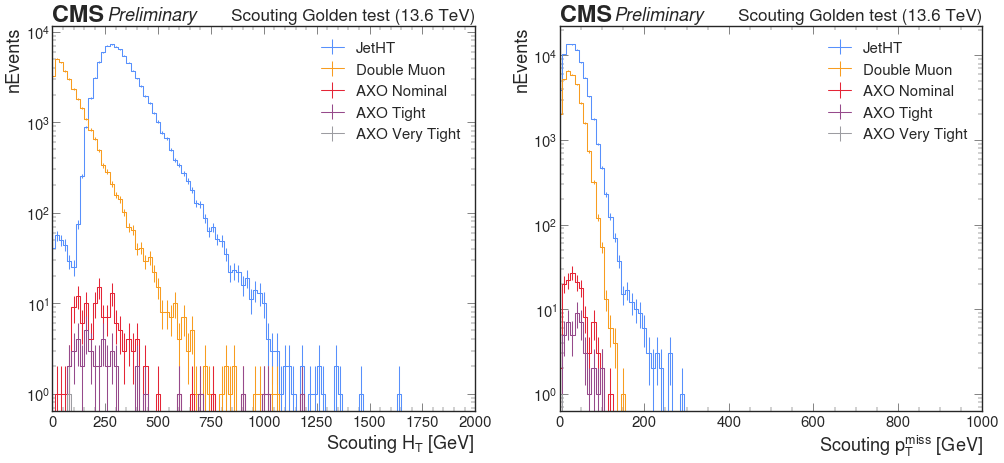

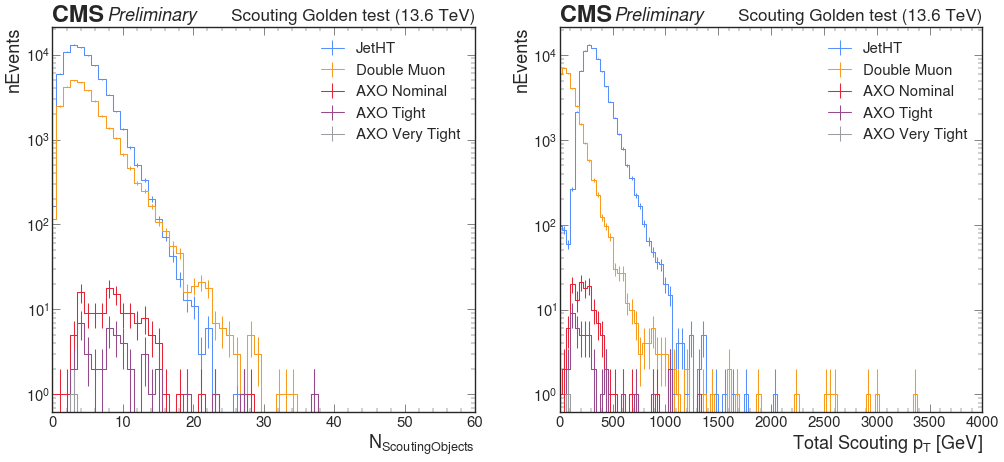

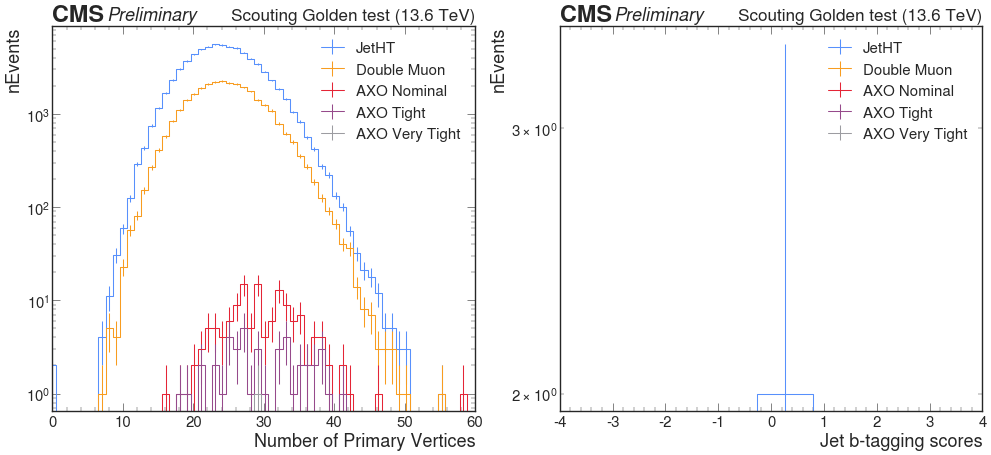

In [139]:
# Scouting Objects 

fig, ax = plt.subplots(1, 2, figsize=(24, 10))

# HT
get_name = lambda suf=None: f'scoutinght_{suf}' if suf else f'scoutinght'
norm = False#

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[0], label='All Events', rebin=1, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[0], label=trigger_names[trigger], rebin=1, norm=norm)

hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[0].set_xlim(0,2000)
ax[0].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[0].set_xlabel(r'Scouting $H_{T}$ [GeV]', loc='right')
ax[0].set_yscale('log')
ax[0].legend();

# MET
get_name = lambda suf=None: f'scoutingmet_{suf}' if suf else f'scoutingmet'
norm = False

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[1], label='All Events', rebin=4, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[1], label=trigger_names[trigger], rebin=1, norm=norm)
            
hep.cms.label('Preliminary', ax=ax[1], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[1].set_xlim(0,1000)
ax[1].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[1].set_xlabel(r'Scouting $p^{miss}_{T}$ [GeV]', loc='right')
ax[1].set_yscale('log')
ax[1].legend();

fig, ax = plt.subplots(1, 2, figsize=(24, 10))

# Total Object Multiplicity
get_name = lambda suf=None: f'total_scoutingmult_{suf}' if suf else f'total_scoutingmult'
norm = False

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[0], label='All Events', rebin=10, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[0], label=trigger_names[trigger], rebin=1, norm=norm)

hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[0].set_xlim(0,60)
ax[0].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[0].set_xlabel(r'$N_{Scouting Objects}$', loc='right')
ax[0].set_yscale('log')
ax[0].legend();

# Total Object Pt
get_name = lambda suf=None: f'total_scoutingpt_{suf}' if suf else f'total_scoutingpt'
norm = False

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[1], label='All Events', rebin=4, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[1], label=trigger_names[trigger], rebin=4, norm=norm)
            
hep.cms.label('Preliminary', ax=ax[1], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[1].set_xlim(0,4000)
ax[1].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[1].set_xlabel(r'Total Scouting $p_{T}$ [GeV]', loc='right')
ax[1].set_yscale('log')
ax[1].legend();


fig, ax = plt.subplots(1, 2, figsize=(24, 10))

# Scouting NPV 
get_name = lambda suf=None: f'scoutingnpv_{suf}' if suf else f'scoutingnpv'
norm = False

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[0], label='All Events', rebin=10, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[0], label=trigger_names[trigger], rebin=1, norm=norm)

hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[0].set_xlim(0,60)
ax[0].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[0].set_xlabel(r'Number of Primary Vertices', loc='right')
ax[0].set_yscale('log')
ax[0].legend();

# Total Object Pt
get_name = lambda suf=None: f'scoutingbjet_{suf}' if suf else f'scoutingbjet'
norm = False

#draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[1], label='All Events', rebin=4, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[1], label=trigger_names[trigger], rebin=4, norm=norm)
            
hep.cms.label('Preliminary', ax=ax[1], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[1].set_xlim(-4,4)
ax[1].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax[1].set_xlabel(r'Jet b-tagging scores', loc='right')
ax[1].set_yscale('log')
ax[1].legend();

multipage("plots/"+histpath[0]+"_1D_reco.pdf", figs=plt.get_fignums(), dpi=200)

## Object-Level Kinematic Plots

### L1 Objects

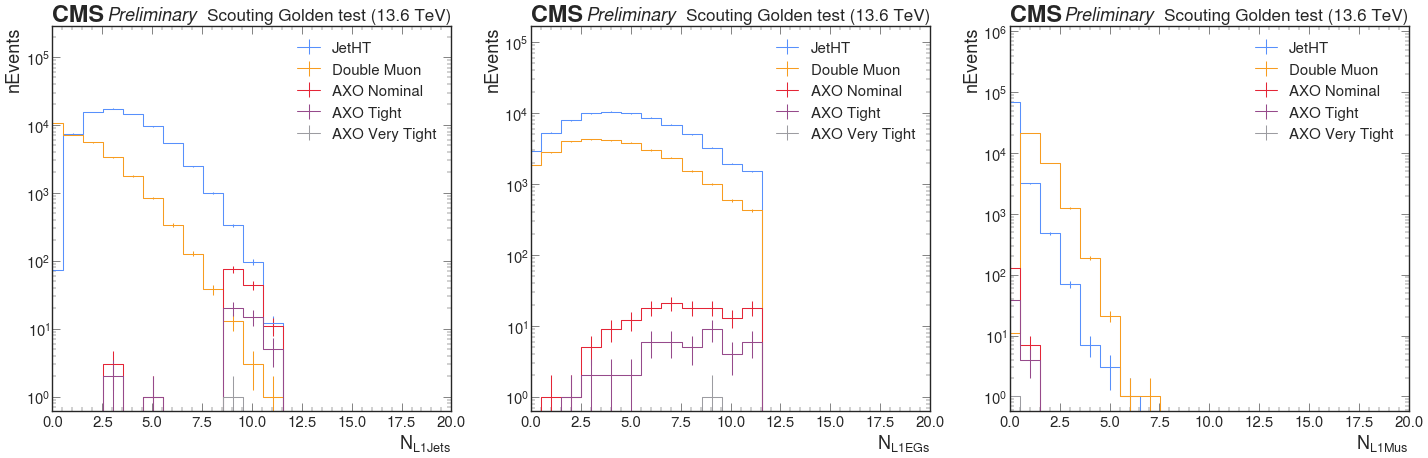

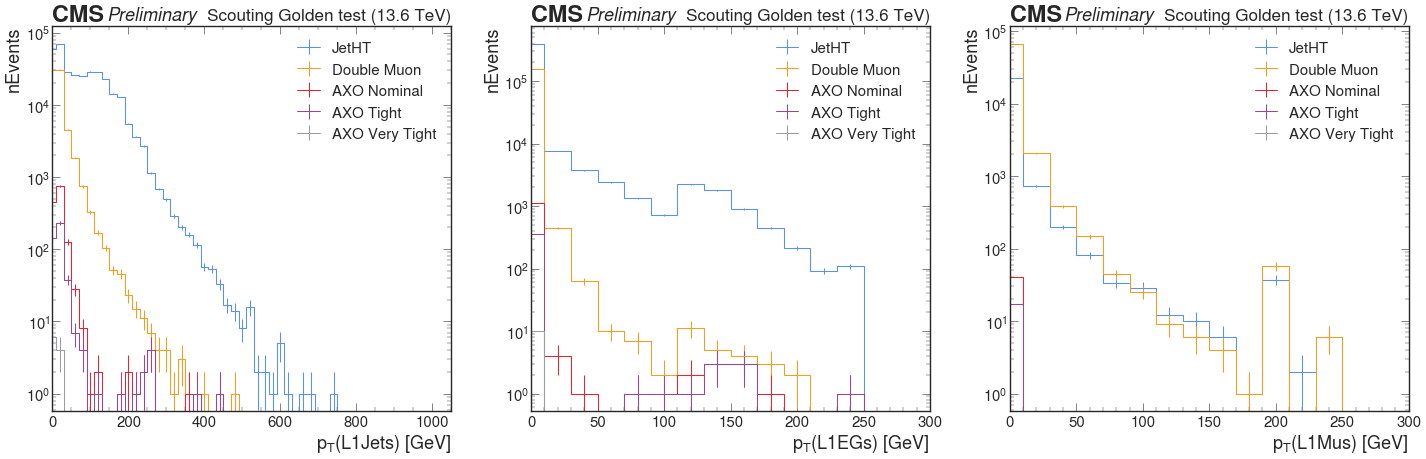

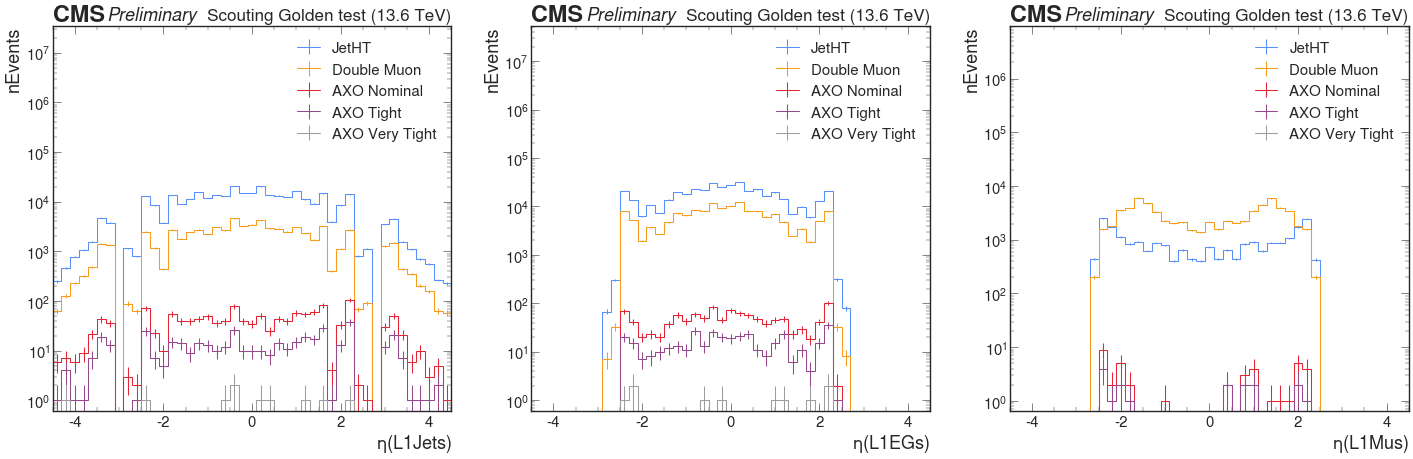

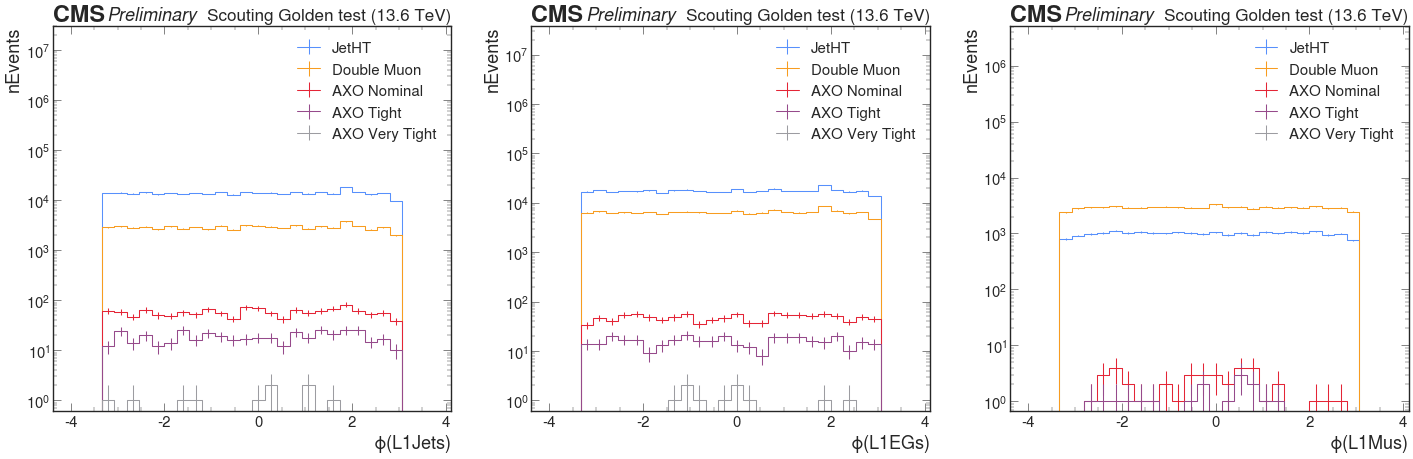

In [140]:
#histpath = ['JetMET_2024D_wScores','hists']
#triggers = ['HLT_L1AXOVTight']
norm = False
l1_objects = ['L1Jet', 'L1EG','L1Mu']

# Multiplicity
get_name = lambda s, suf=None: f'n_{obj}_{suf}' if suf else f'n_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,20), (0,20), (0,20)]
for i, obj in enumerate(l1_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=1, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=1, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ymin, ymax = ax[i].get_ylim()
    ax[i].set_ylim((ymin,ymax*10))
    ax[i].legend(loc='upper right')


# Pt
get_name = lambda s, suf=None: f'pt_{obj}_{suf}' if suf else f'pt_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,1050), (0,300), (0,300)]
for i, obj in enumerate(l1_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=4, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=2, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ymin, ymax = ax[i].get_ylim()
    ax[i].set_ylim((ymin,ymax*1))
    ax[i].legend(loc='upper right')



# Eta  
get_name = lambda s, suf=None: f'eta_{obj}_{suf}' if suf else f'eta_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(l1_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=2, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=3, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_xlim((-4.5,4.5))
    ax[i].set_yscale('log')
    ymin, ymax = ax[i].get_ylim()
    ax[i].set_ylim((ymin,ymax*1000))
    ax[i].legend(loc='upper right')


# Phi
get_name = lambda s, suf=None: f'phi_{obj}_{suf}' if suf else f'phi_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(l1_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=1, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=1, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ymin, ymax = ax[i].get_ylim()
    ax[i].set_ylim((ymin,ymax*1000))
    ax[i].legend(loc='upper right')
multipage("plots/"+histpath[0]+"_1D_L1objs.pdf", figs=plt.get_fignums(), dpi=200)

### RECO Objects

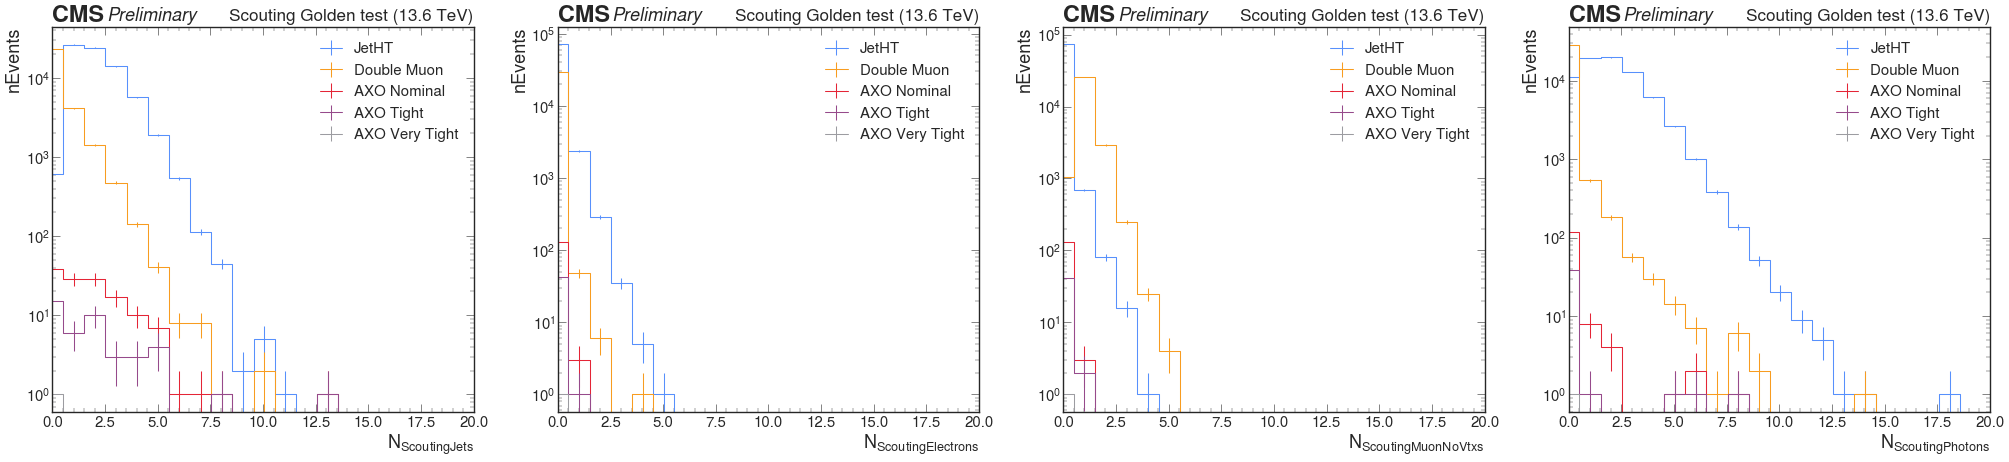

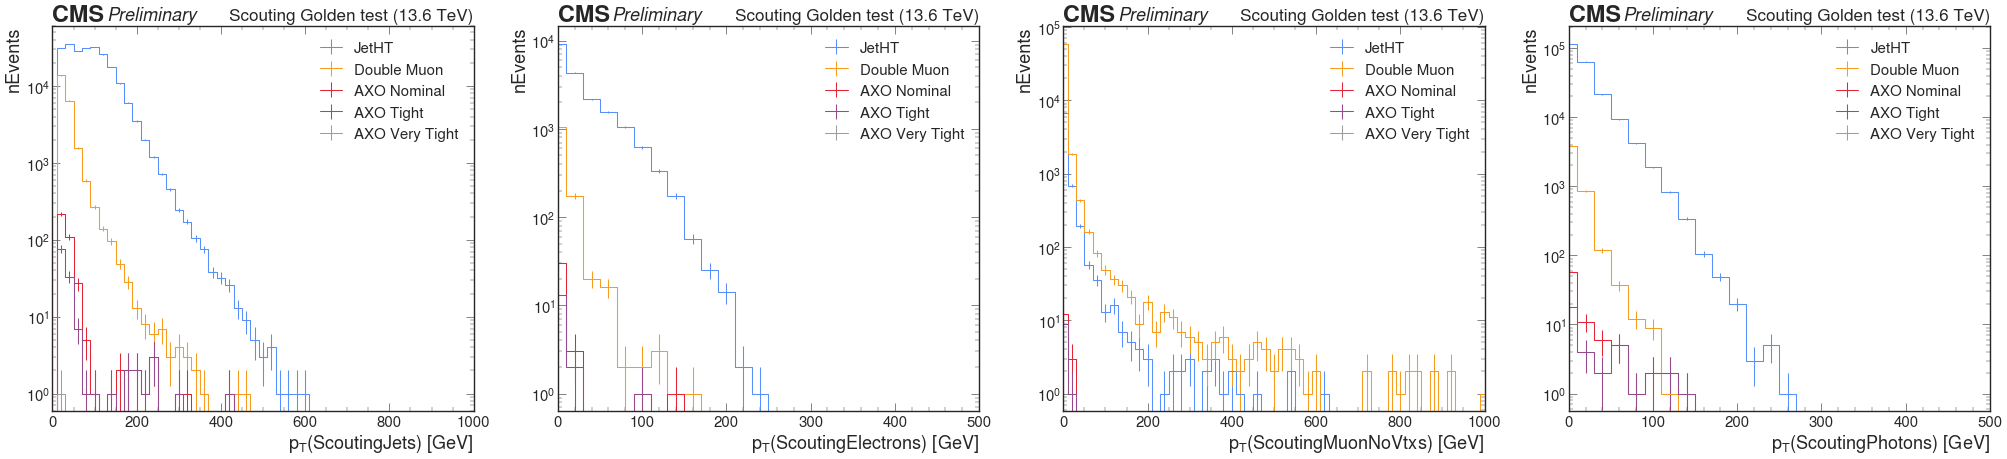

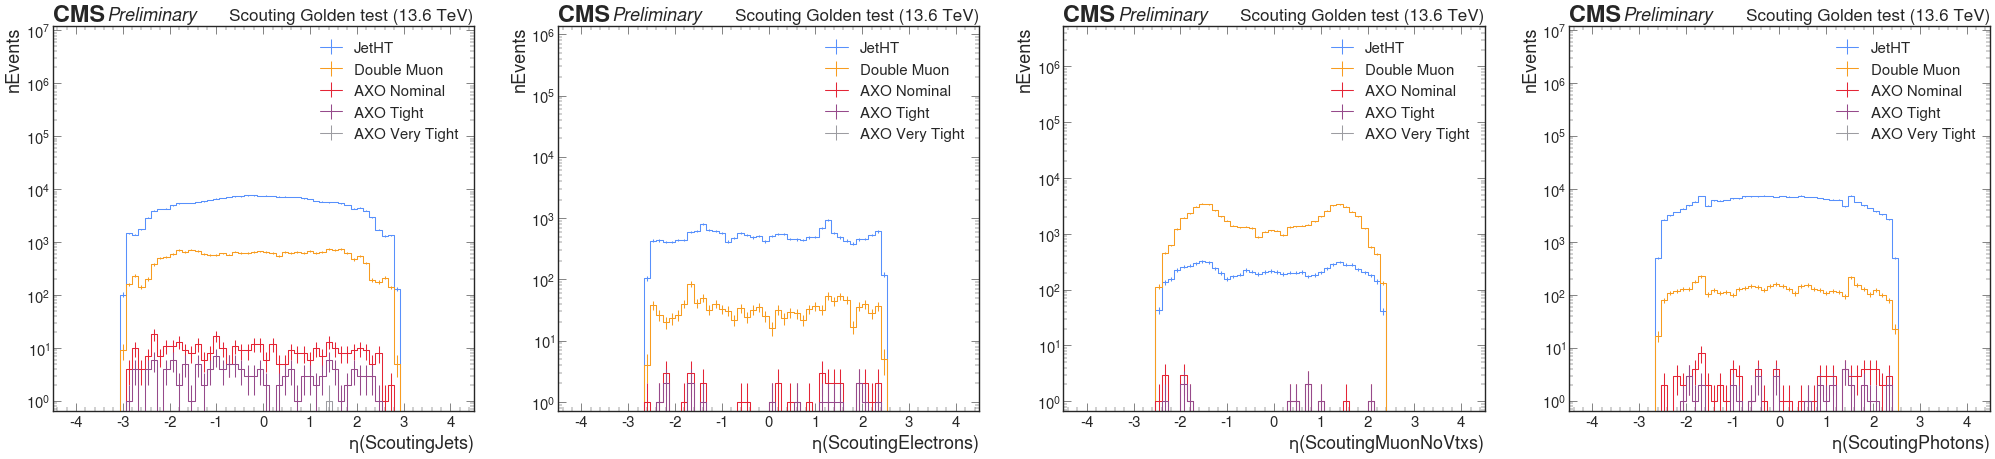

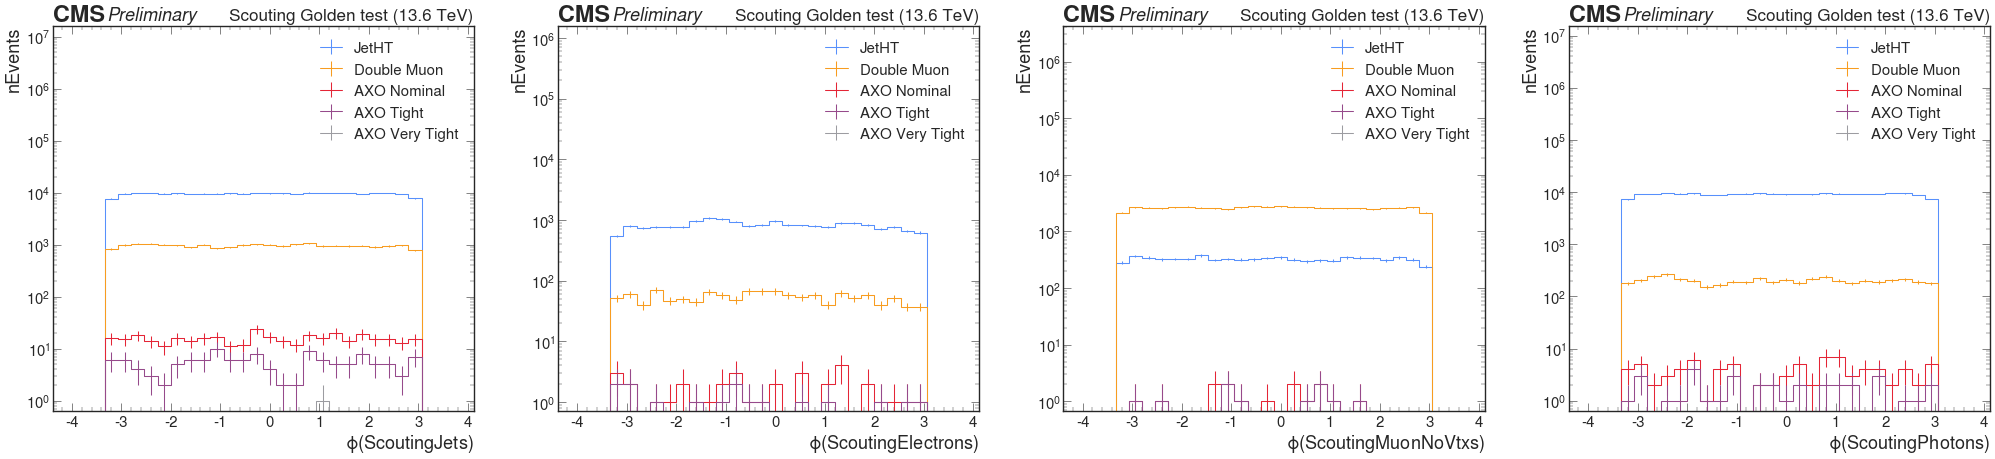

In [141]:
#histpath = ['JetMET_2024D_wScores','hists']
#triggers = ['HLT_L1AXOVTight']
n = len(reco_objects)
width = n*10+10
# Multiplicity
get_name = lambda s, suf=None: f'n_{obj}_{suf}' if suf else f'n_{obj}'
fig, ax = plt.subplots(1, n, figsize=(width, 10))
xrange = [(0,20), (0,20), (0,20), (0,20)]
norm = False
for i, obj in enumerate(reco_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=1, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=1, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()


# Pt
get_name = lambda s, suf=None: f'pt_{obj}_{suf}' if suf else f'pt_{obj}'
fig, ax = plt.subplots(1, n, figsize=(width, 10))
xrange = [(0,1000), (0,500), (0,1000), (0,500)]
for i, obj in enumerate(reco_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=4, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=2, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()


# Eta  
get_name = lambda s, suf=None: f'eta_{obj}_{suf}' if suf else f'eta_{obj}'
fig, ax = plt.subplots(1, n, figsize=(width, 10))
for i, obj in enumerate(reco_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=2, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=2, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_xlim((-4.5,4.5))
    ax[i].set_yscale('log')
    ymin, ymax = ax[i].get_ylim()
    ax[i].set_ylim((ymin,ymax*1000))
    ax[i].legend(loc='upper right')


# Phi
get_name = lambda s, suf=None: f'phi_{obj}_{suf}' if suf else f'phi_{obj}'
fig, ax = plt.subplots(1, n, figsize=(width, 10))
for i, obj in enumerate(reco_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=2, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=1, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ymin, ymax = ax[i].get_ylim()
    ax[i].set_ylim((ymin,ymax*1000))
    ax[i].legend(loc='upper right')
multipage("plots/"+histpath[0]+"_1D_recoobjs.pdf", figs=plt.get_fignums(), dpi=200)

## Di-Object Mass Plots

### L1 Objects

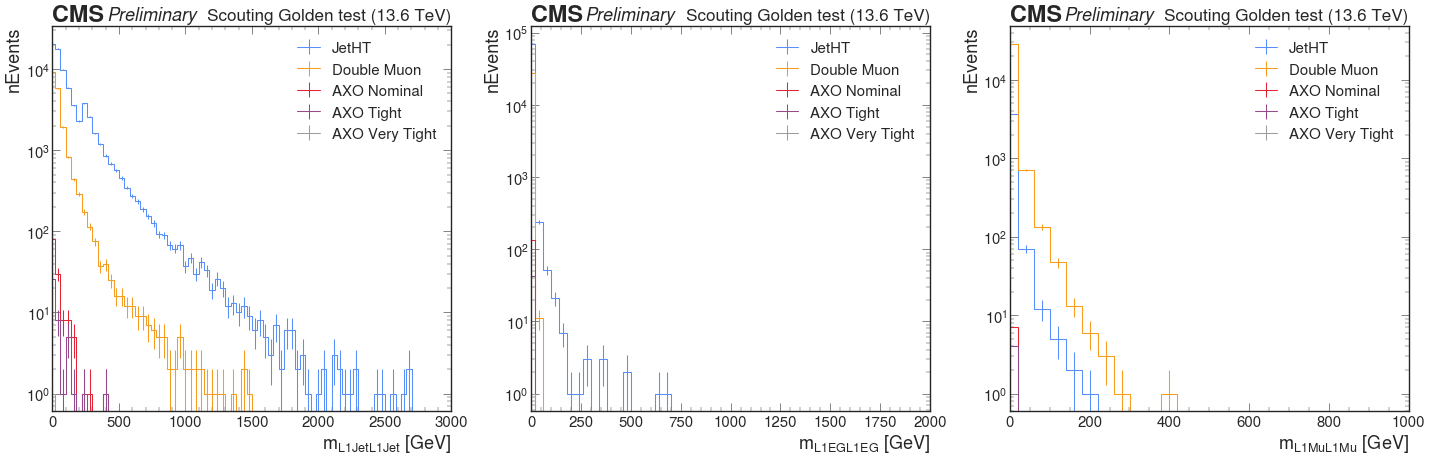

In [142]:
#histpath = ['JetMET_2024D_wScores','hists']
#triggers = ['HLT_L1AXOVTight']

get_name = lambda s, suf=None: f'm{obj}{obj}_{suf}' if suf else f'm{obj}{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,3000), (0,2000), (0,1000)]
norm = False
for i, obj in enumerate(l1_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=10, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=40, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$m_{{{obj}{obj}}}$ [GeV]', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()
multipage("plots/"+histpath[0]+"_1D_m_L1.pdf", figs=plt.get_fignums(), dpi=200)

### RECO Objects

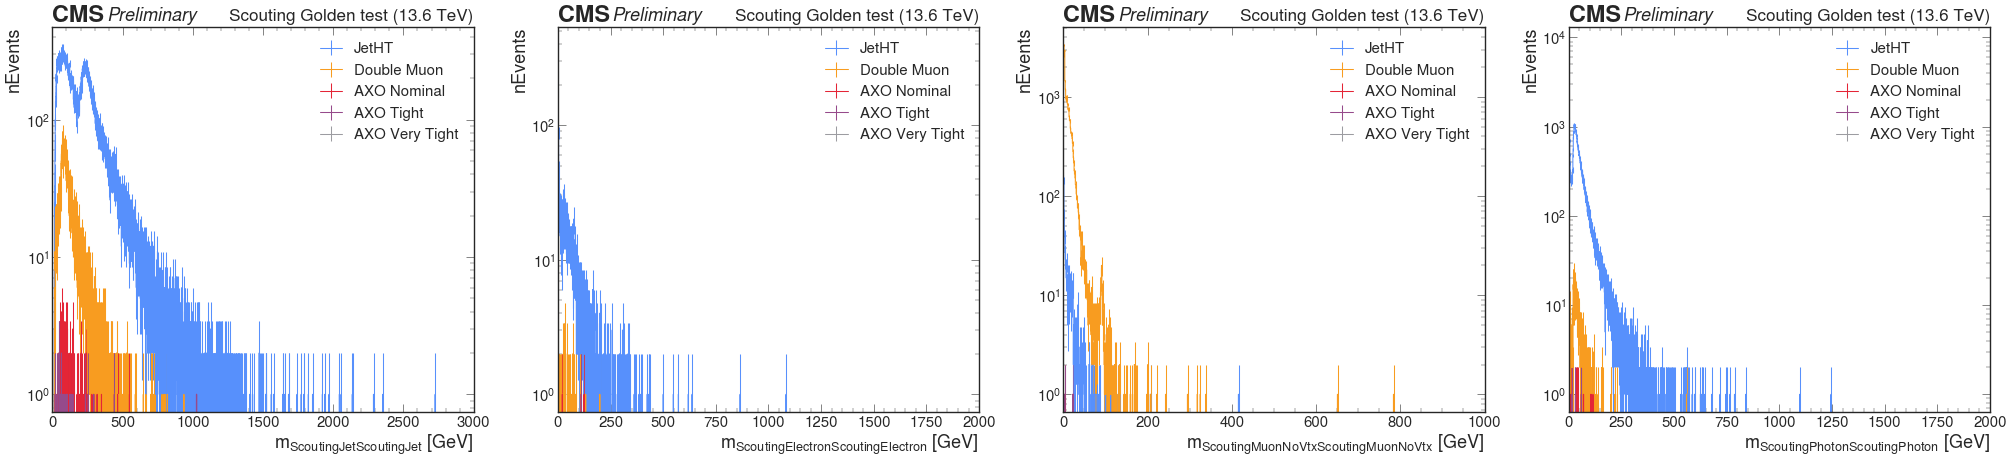

In [145]:
#histpath = ['JetMET_2024D_wScores','hists']
#triggers = ['HLT_L1AXOVTight']

get_name = lambda s, suf=None: f'm{obj}{obj}_{suf}' if suf else f'm{obj}{obj}'
fig, ax = plt.subplots(1, n, figsize=(width, 10))
xrange = [(0,3000), (0,2000), (0,1000),(0,2000)]
norm = False
for i, obj in enumerate(reco_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=10, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=10, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$m_{{{obj}{obj}}}$ [GeV]', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()
multipage("plots/"+histpath[0]+"_1D_m_reco.pdf", figs=plt.get_fignums(), dpi=200)

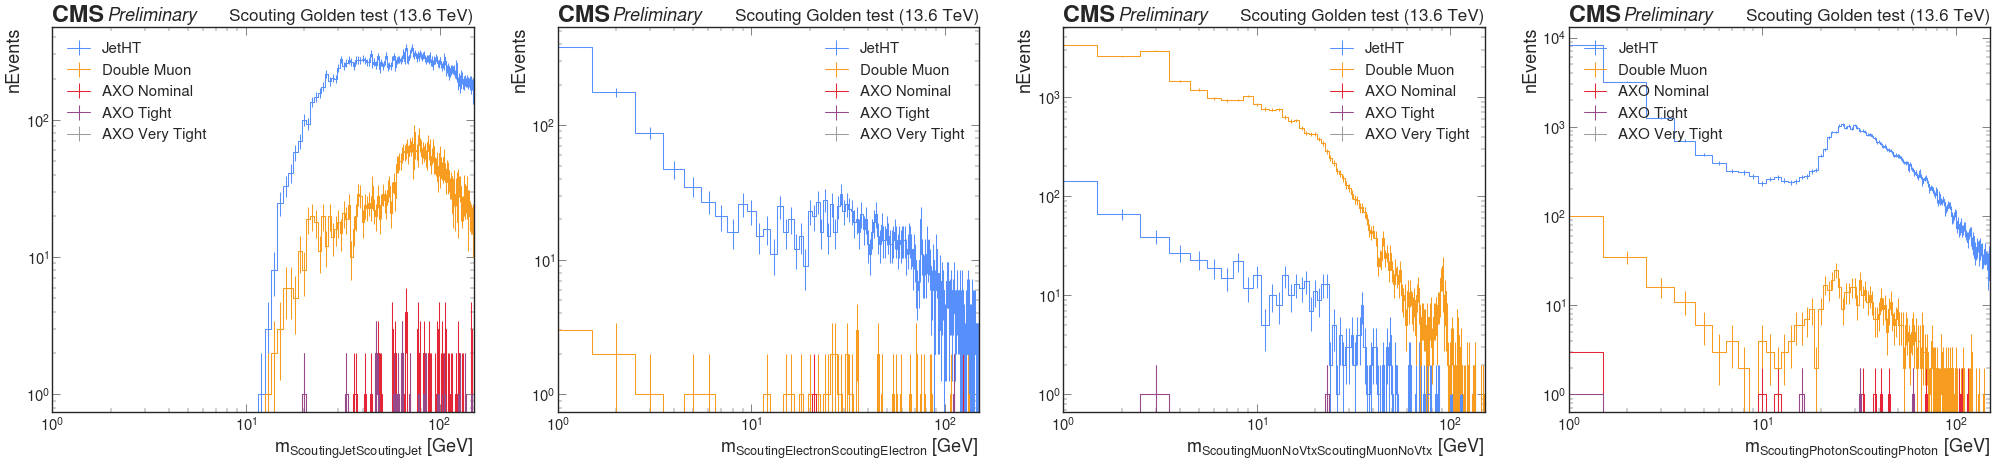

In [152]:
get_name = lambda s, suf=None: f'm{obj}{obj}_{suf}' if suf else f'm{obj}{obj}'
fig, ax = plt.subplots(1, n, figsize=(width, 10))
xrange = [(0,150), (0,150), (0,150), (0,150)]
norm = False
for i, obj in enumerate(reco_objects):
    #draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=10, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger_names[trigger], rebin=4, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$m_{{{obj}{obj}}}$ [GeV]', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()
multipage("plots/"+histpath[0]+"_all.pdf", figs=plt.get_fignums(), dpi=200)

In [50]:
cutflow = hist_result['Scouting_380470']['cutflow']


dict_values([dask.awkward<num, type=Scalar, dtype=int64, known_value=166688022>, dask.awkward<numaxis0, type=Scalar, dtype=int64>, dask.awkward<numaxis0, type=Scalar, dtype=int64>, dask.awkward<numaxis0, type=Scalar, dtype=int64>, dask.awkward<numaxis0, type=Scalar, dtype=int64>, dask.awkward<numaxis0, type=Scalar, dtype=int64>, dask.awkward<numaxis0, type=Scalar, dtype=int64>, dask.awkward<numaxis0, type=Scalar, dtype=int64>, dask.awkward<numaxis0, type=Scalar, dtype=int64>, dask.awkward<numaxis0, type=Scalar, dtype=int64>, dask.awkward<numaxis0, type=Scalar, dtype=int64>])

## 2D Correlation Plots

### L1 Objects

DST_PFScouting_JetHT


KeyError: 'eta_pt_L1Jet_DST_PFScouting_JetHT'

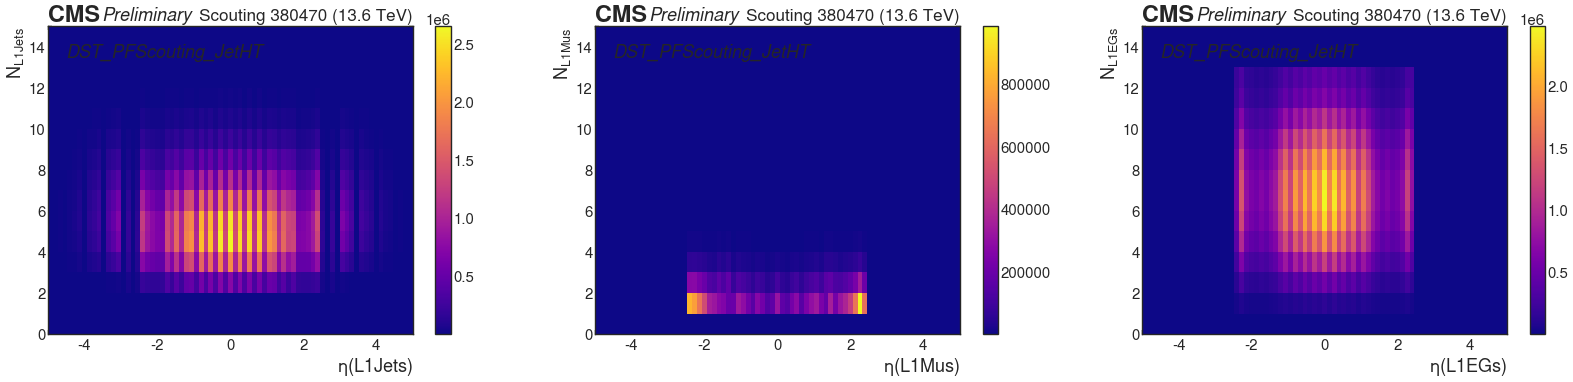

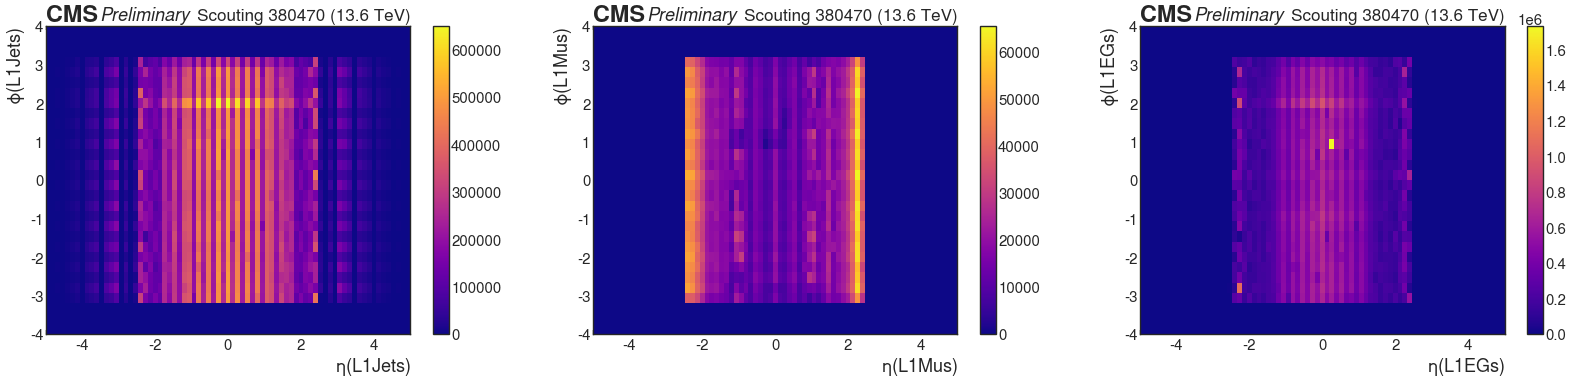

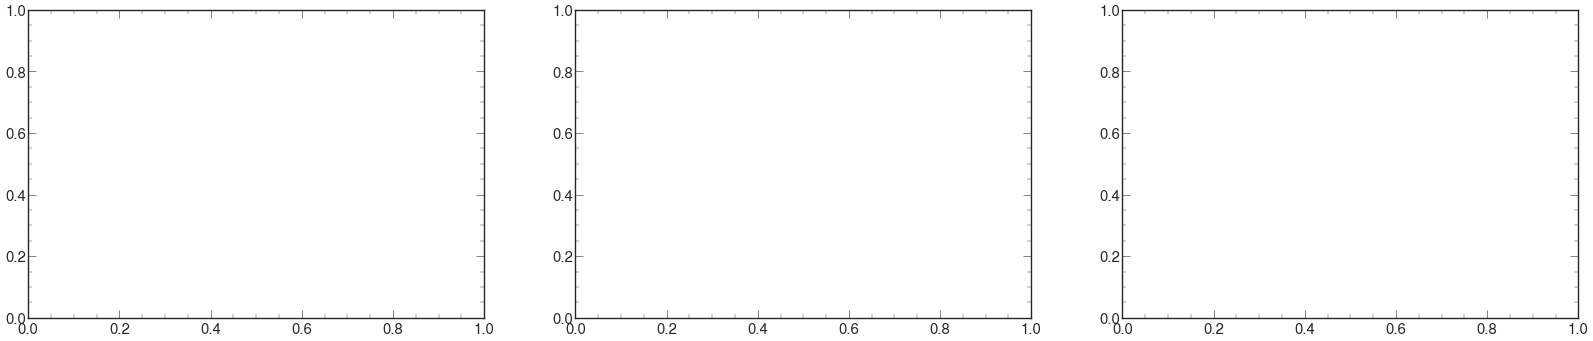

In [112]:
#histpath = ['JetMET_2024D_wScores','hists']
#triggers = ['HLT_L1AXOVTight']

for trigger in triggers:
    print(trigger)
    # Mult vs. Eta
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    get_name = lambda s, suf=None: f'n_eta_{obj}_{suf}' if suf else f'n_eta_{obj}'
    # xrange = [(0,10), (0,10), (0,15)]
    yrange = [(0,15), (0,15), (0,15)]
    norm = True
    for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','mult', x_rebin=1, y_rebin=2, norm=norm)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        hep.cms.text(text=trigger,loc=2,exp="",ax=ax[i])
        # ax[i].set_xlim(*xrange[i])
        ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
        ax[i].set_ylabel(f'$N_{{{obj+"s"}}}$', loc='top')
        fig.colorbar(mesh)

    # Eta vs. Phi
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    get_name = lambda s, suf=None: f'eta_phi_{obj}_{suf}' if suf else f'eta_phi_{obj}'
    # xrange = [(0,10), (0,10), (0,15)]
    # yrange = [(1500,4000), (980,4000), (980,4000)]
    norm = False
    for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','phi', x_rebin=2, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        # ax[i].set_xlim(*xrange[i])
        # ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
        ax[i].set_ylabel(f'$\phi({obj+"s"})$', loc='top')
        fig.colorbar(mesh)
        
    # Eta vs. Pt
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    get_name = lambda s, suf=None: f'eta_pt_{obj}_{suf}' if suf else f'eta_pt_{obj}'
    # xrange = [(0,10), (0,10), (0,15)]
    # yrange = [(1500,4000), (980,4000), (980,4000)]
    norm = False
    for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','pt', x_rebin=2, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        # ax[i].set_xlim(*xrange[i])
        # ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
        ax[i].set_ylabel(f'$\pt({obj+"s"})$', loc='top')
        fig.colorbar(mesh)
        
    if has_scores:
        fig, ax = plt.subplots(1, 2, figsize=(26, 8))

        #  Score vs. Total Multiplicity
        get_name = lambda s, suf=None: f'anomaly_score_total_mult_{suf}' if suf else f'anomaly_score_total_mult'
        xrange = (0,80)
        yrange = (1500,4000)
        norm = False

        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[0], 'mult','score', x_rebin=1, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[0].set_xlim(*xrange)
        ax[0].set_ylim(*yrange)
        ax[0].set_xlabel(r'$N_{L1 Objects}$', loc='right')
        ax[0].set_ylabel('Anomaly Score', loc='top')
        fig.colorbar(mesh)

        #  Score vs. Total Pt
        get_name = lambda s, suf=None: f'anomaly_score_total_pt_{suf}' if suf else f'anomaly_score_total_pt'
        xrange = (0,4000)
        yrange = (1500,4000)
        norm = False

        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[1], 'pt','score', x_rebin=1, y_rebin=4, norm=False)

        hep.cms.label('Preliminary', ax=ax[1], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[1].set_xlim(*xrange)
        ax[1].set_ylim(*yrange)
        ax[1].set_xlabel(r'Total L1 $p_{T}$ [GeV]', loc='right')
        ax[1].set_ylabel('Anomaly Score', loc='top')
        fig.colorbar(mesh)

        # Score vs. Multiplicity
        fig, ax = plt.subplots(1, 3, figsize=(40, 8))
        get_name = lambda s, suf=None: f'anomaly_score_n_{obj}_{suf}' if suf else f'anomaly_score_n_{obj}'
        xrange = [(0,10), (0,10), (0,15)]
        yrange = [(1500,4000), (1500,4000), (1500,4000)]
        norm = False
        for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
            mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'mult','score', x_rebin=1, y_rebin=1, norm=False)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_ylim(*yrange[i])
            ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
            ax[i].set_ylabel('Anomaly Score', loc='top')
            fig.colorbar(mesh)

        #  Score vs. Pt
        fig, ax = plt.subplots(1, 3, figsize=(40, 8))
        get_name = lambda s, suf=None: f'anomaly_score_pt_{obj}_{suf}' if suf else f'anomaly_score_pt_{obj}'
        xrange = [(0,500), (0,300), (0,300)]
        yrange = [(1500,4000), (1500,4000), (1500,4000)]
        norm = False
        for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
            mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'pt','score', x_rebin=1, y_rebin=1, norm=True)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_ylim(*yrange[i])
            ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
            ax[i].set_ylabel('Anomaly Score', loc='top')
            fig.colorbar(mesh)

        #  Score vs. Eta
        fig, ax = plt.subplots(1, 3, figsize=(40, 8))
        get_name = lambda s, suf=None: f'anomaly_score_eta_{obj}_{suf}' if suf else f'anomaly_score_eta_{obj}'
        # xrange = [(0,4000), (0,4000), (0,4000)]
        yrange = [(1500,4000), (1500,4000), (1500,4000)]
        norm = False
        for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
            mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','score', x_rebin=1, y_rebin=1, norm=False)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
            # ax[i].set_xlim(*xrange[i])
            ax[i].set_ylim(*yrange[i])
            ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
            ax[i].set_ylabel('Anomaly Score', loc='top')
            fig.colorbar(mesh)


        #  Score vs. Phi
        fig, ax = plt.subplots(1, 3, figsize=(40, 8))
        get_name = lambda s, suf=None: f'anomaly_score_phi_{obj}_{suf}' if suf else f'anomaly_score_phi_{obj}'
        # xrange = [(0,4000), (0,4000), (0,4000)]
        yrange = [(1500,4000), (1500,4000), (1500,4000)]
        norm = False
        for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
            mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'phi','score', x_rebin=1, y_rebin=1, norm=False)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
            # ax[i].set_xlim(*xrange[i])
            ax[i].set_ylim(*yrange[i])
            ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
            ax[i].set_ylabel('Anomaly Score', loc='top')
            fig.colorbar(mesh)
multipage("plots/"+histpath[0]+"_2D_L1.pdf", figs=plt.get_fignums(), dpi=200)

### RECO Objects

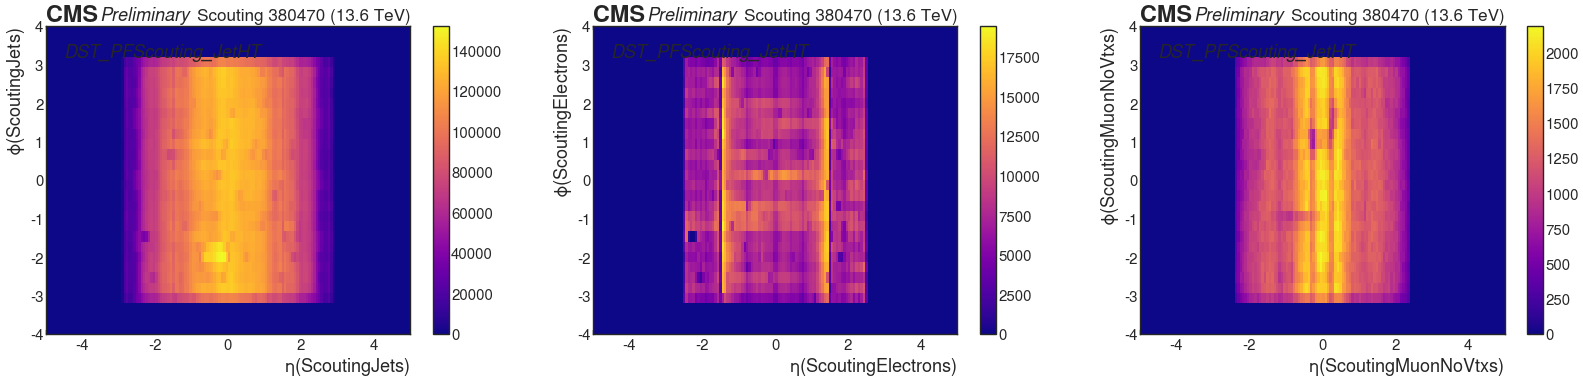

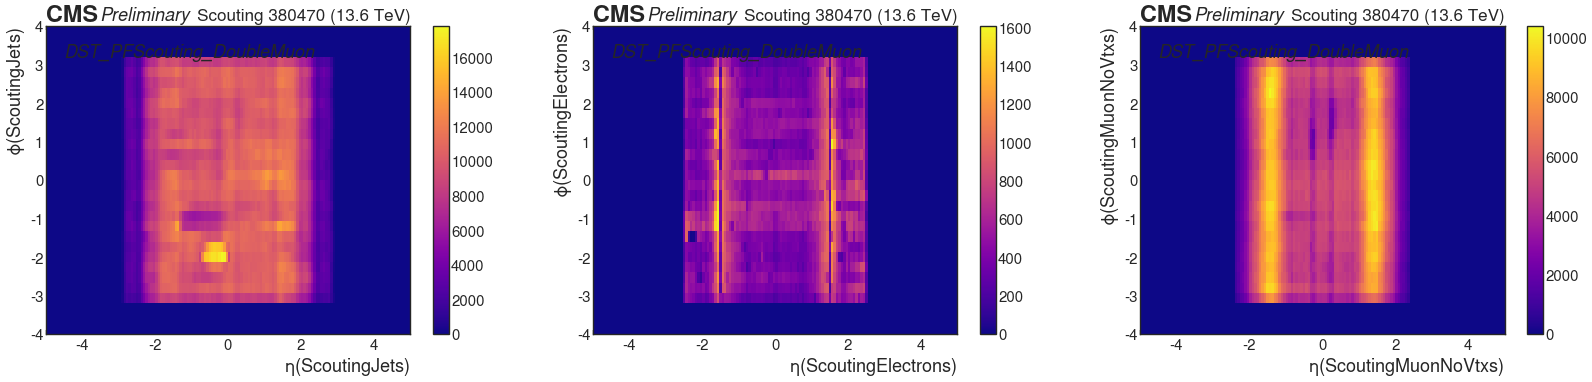

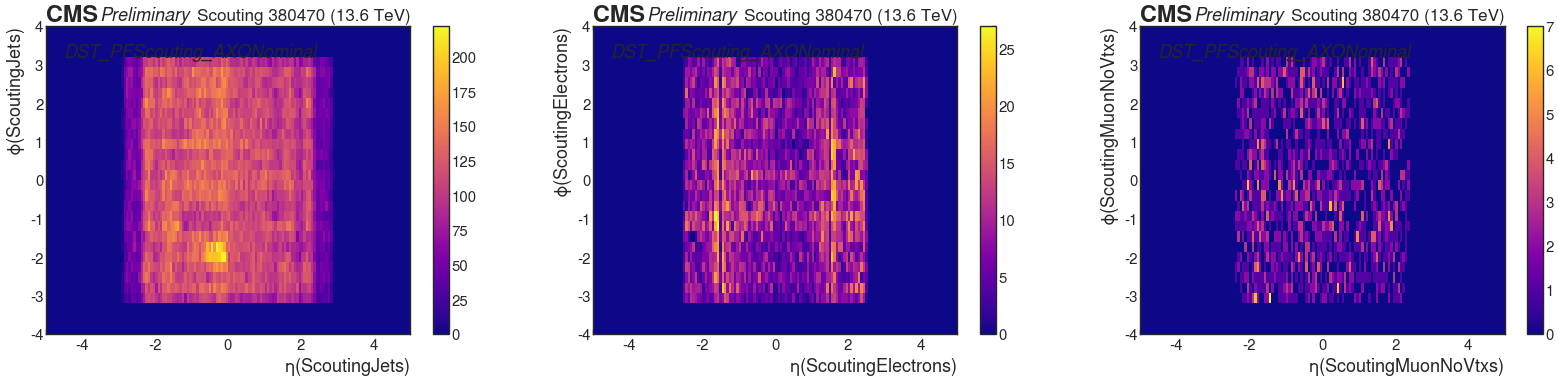

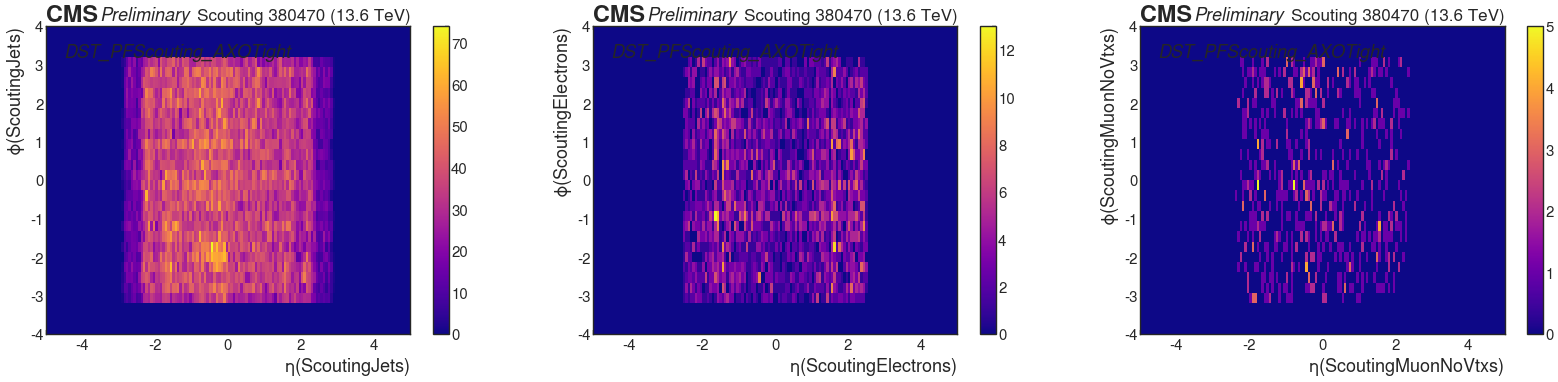

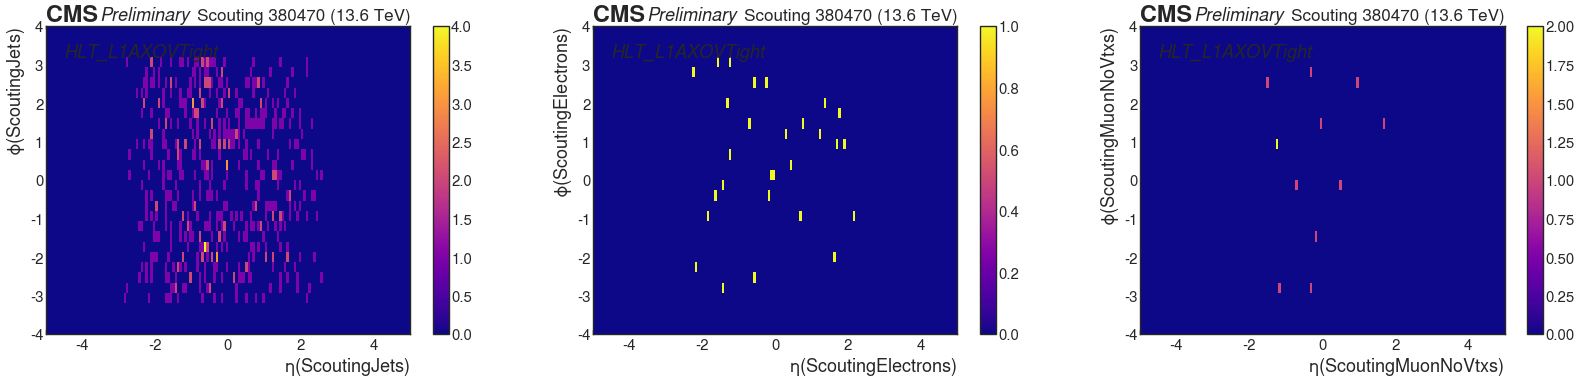

In [103]:
#histpath = ['JetMET_2024D_wScores','hists']
#triggers = ['HLT_L1AXOVTight']
cmap = plt.get_cmap('plasma')

for trigger in triggers:
    # Eta vs. Phi
    get_name = lambda s, suf=None: f'eta_phi_{obj}_{suf}' if suf else f'eta_phi_{obj}'
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    # xrange = [(0,10), (0,10), (0,15)]
    # yrange = [(1500,4000), (980,4000), (980,4000)]
    norm = False
    for i, obj in enumerate(reco_objects):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','phi', x_rebin=1, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        hep.cms.text(text=trigger,loc=2,exp="",ax=ax[i])

        # ax[i].set_xlim(*xrange[i])
        # ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
        ax[i].set_ylabel(f'$\phi({obj+"s"})$', loc='top')
        fig.colorbar(mesh)
    
    if has_scores:

        # Score vs. Multiplicity
        get_name = lambda s, suf=None: f'anomaly_score_n_{obj}_{suf}' if suf else f'anomaly_score_n_{obj}'
        fig, ax = plt.subplots(1, 3, figsize=(40, 8))
        xrange = [(0,10), (0,10), (0,15)]
        yrange = [(1500,4000), (1500,4000), (1500,4000)]
        norm = False
        for i, obj in enumerate(reco_objects):
            mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'mult','score', x_rebin=2, y_rebin=1, norm=False)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_ylim(*yrange[i])
            ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
            ax[i].set_ylabel('Anomaly Score', loc='top')
            fig.colorbar(mesh)

        #  Score vs. Pt
        get_name = lambda s, suf=None: f'anomaly_score_pt_{obj}_{suf}' if suf else f'anomaly_score_pt_{obj}'
        fig, ax = plt.subplots(1, 3, figsize=(40, 8))
        xrange = [(0,500), (0,300), (0,300)]
        yrange = [(1500,4000), (1500,4000), (1500,4000)]
        norm = False
        for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
            mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'pt','score', x_rebin=1, y_rebin=1, norm=True)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_ylim(*yrange[i])
            ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
            ax[i].set_ylabel('Anomaly Score', loc='top')
            fig.colorbar(mesh)

        #  Score vs. Eta
        get_name = lambda s, suf=None: f'anomaly_score_eta_{obj}_{suf}' if suf else f'anomaly_score_eta_{obj}'
        fig, ax = plt.subplots(1, 3, figsize=(40, 8))
        # xrange = [(0,4000), (0,4000), (0,4000)]
        yrange = [(1500,4000), (1500,4000), (1500,4000)]
        norm = False
        for i, obj in enumerate(reco_objects):
            mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','score', x_rebin=1, y_rebin=1, norm=False)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
            # ax[i].set_xlim(*xrange[i])
            ax[i].set_ylim(*yrange[i])
            ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
            ax[i].set_ylabel('Anomaly Score', loc='top')
            fig.colorbar(mesh)

        #  Score vs. Phi
        get_name = lambda s, suf=None: f'anomaly_score_phi_{obj}_{suf}' if suf else f'anomaly_score_phi_{obj}'
        fig, ax = plt.subplots(1, 3, figsize=(40, 8))
        # xrange = [(0,4000), (0,4000), (0,4000)]
        yrange = [(1500,4000), (1500,4000), (1500,4000)]
        norm = False
        for i, obj in enumerate(reco_objects):
            mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'phi','score', x_rebin=1, y_rebin=1, norm=False)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
            # ax[i].set_xlim(*xrange[i])
            ax[i].set_ylim(*yrange[i])
            ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
            ax[i].set_ylabel('Anomaly Score', loc='top')
            fig.colorbar(mesh)
multipage("plots/"+histpath[0]+"_2D_reco.pdf", figs=plt.get_fignums(), dpi=200)

# Z peak

In [87]:
hist_result['Scouting_380470']['cutflow']['start']

dask.awkward<num, type=Scalar, dtype=int64, known_value=166688022>

In [97]:
hist_result['Scouting_380470']['cutflow']['DST_PFScouting_JetHT']

dask.awkward<count, type=Scalar, dtype=int64>

In [62]:
tstart = time.time()
cutflow = {k:v.compute() for k,v in hist_result[histpath[0]]['cutflow'].items()}
cutflow_df = pd.DataFrame(cutflow.values(),index=cutflow.keys())
display(cutflow_df)
print(f'{time.time()-tstart:.1f}s to process')

KeyboardInterrupt: 

In [ ]:
#histpath = ['JetMET_Run380310_test_wScores','hists']
#histpath = ['JetMET_Run380310_test','hists']

#triggers = ['HLT_L1AXOVTight'] 
triggers = ['DST_PFScouting_JetHT','DST_PFScouting_DoubleMuon','DST_PFScouting_AXONominal','DST_PFScouting_AXOTight','HLT_L1AXOVTight']
#triggers = ['DST_PFScouting_DoubleMuon']

has_scores = True if 'wScores' in histpath[0] else False
is_scouting = True if 'Scouting' in histpath[0] else False
if is_scouting:
    reco_objects = ["ScoutingJet","ScoutingElectron","ScoutingMuonNoVtx"]
else:
    reco_objects = ["Jet","Electron","Muon"]


tstart = time.time()
to_compute = apply_to_fileset(
                MakeZHists(trigger_paths=triggers, 
                             has_scores=has_scores, 
                             is_scouting=is_scouting),
                max_chunks(dataset_runnable, 300),
                schemaclass=ScoutingNanoAODSchema,
                uproot_options={"allow_read_errors_with_report": (OSError, TypeError, KeyError)}
            )
(hist_result,) = dask.compute(to_compute)
print(f'{time.time()-tstart:.1f}s to process')
hist_result = hist_result[0]
histpath = ['Scouting_380470','hists']

In [ ]:
histpath = ['Scouting_Golden_test','hists']
get_name = lambda s, suf=None: f'm{obj}{obj}_{suf}' if suf else f'm{obj}{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,1000), (0,500), (0,300)]
norm = False
for i, obj in enumerate(reco_objects):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=1, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=1, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$m_{{{obj}{obj}}}$ [GeV]', loc='right')
    ax[i].set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()

[]

/tmp/ipykernel_7797/3150811086.py:27: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  pp.close()


# Testing

In [94]:
import uproot as ur
#fname = 'root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_43.root'
fname = "root://xcache//store/user/pinkaew/scouting_nano_stable/ScoutingPFRun3/crab_ScoutingPFRun3_Run2024D-v1_380255-380649/240514_222828/0004/step2_NANO_4010.root"
f = ur.open(f'{fname}:Events')
# [k for k in f.keys() if (('L1_' not in k) and ('HLT_' not in k))]

events = NanoEventsFactory.from_root(
    {fname:"Events"},
    schemaclass=NanoAODSchema,
).events()

In [57]:
[k for k in f.keys() if ('L1EtSum' in k)]

['nL1EtSum', 'L1EtSum_bx', 'L1EtSum_etSumType', 'L1EtSum_phi', 'L1EtSum_pt']

In [95]:
[k for k in f.keys() if ('ScoutingJet' in k)]

['nScoutingJet',
 'ScoutingJet_nConstituents',
 'ScoutingJet_nCh',
 'ScoutingJet_nElectrons',
 'ScoutingJet_nMuons',
 'ScoutingJet_nNh',
 'ScoutingJet_nPhotons',
 'ScoutingJet_area',
 'ScoutingJet_chEmEF',
 'ScoutingJet_chHEF',
 'ScoutingJet_eta',
 'ScoutingJet_mass',
 'ScoutingJet_muEF',
 'ScoutingJet_neEmEF',
 'ScoutingJet_neHEF',
 'ScoutingJet_phi',
 'ScoutingJet_pt',
 'ScoutingJet_particleNet_prob_b',
 'ScoutingJet_particleNet_prob_bb',
 'ScoutingJet_particleNet_prob_c',
 'ScoutingJet_particleNet_prob_cc',
 'ScoutingJet_particleNet_prob_g',
 'ScoutingJet_particleNet_prob_undef',
 'ScoutingJet_particlenet_prob_uds']

In [97]:
events.ScoutingJet.particleNet_prob_b

dask.awkward<particleNet-prob-b, npartitions=1>

In [73]:
x = (events[dak.num(events.ScoutingMuonNoVtx)>=2])

In [76]:
x.ScoutingMuonNoVtx.pt.compute()

<Array [[11.2, 7.32], [...], ..., [8.15, 10.3]] type='272562 * var * float3...'>

In [93]:
y = events[dak.sum(events.ScoutingMuonNoVtx.charge,axis=1)==0]

In [94]:
y.ScoutingMuonNoVtx.charge.compute()

<Array [[], [], [1, -1], ..., [], [1, -1]] type='761710 * var * int32[param...'>

In [97]:
events[(dak.num(events.ScoutingMuonNoVtx,axis=1)==2) & (dak.sum(events.ScoutingMuonNoVtx.charge,axis=1)==0)]

dask.awkward<getitem, npartitions=1>

In [119]:
#events.ScoutingMuonNoVtx.#[:,0]#+events.ScoutingMuonNoVtx[:,1]

AttributeError: i0 not in fields.

## Run Pure Event Processor

In [10]:
tstart = time.time()
to_compute = apply_to_fileset(
                PureEvents('HLT_L1AXOVTight', active_l1_seeds),
                max_chunks(dataset_runnable, 300),
                schemaclass=NanoAODSchema,
            )
(hist_result,) = dask.compute(to_compute)
print(f'{time.time()-tstart:.1f}s to process')

0.0s to process


# Investigating Pure Events

In [43]:
l1_seed_df = pd.read_csv(url)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(l1_seed_df[l1_seed_df['2p0E34']>0][['Name','2p0E34']])

,Name,2p0E34
9,L1_SingleMu0_BMTF,2000
19,L1_SingleMu3,22000
20,L1_SingleMu5,4400
22,L1_SingleMu7,2200
24,L1_SingleMu11_SQ14_BMTF,1
28,L1_SingleMu15_DQ,325
29,L1_SingleMu18,210
33,L1_SingleMu22,1
37,L1_SingleMu25,1
40,L1_DoubleMu0_SQ,1500


In [61]:
cutflow = {k:v.compute() for k,v in hist_result['JetMET_2024D_wScores']['cutflow'].items()}

In [62]:
cutflow_df = pd.DataFrame(cutflow.values(),index=cutflow.keys())
display(cutflow_df)

,0
start,11310768
AXO_total,6749
not_firing_L1s,1017511
AXO_pure,71


In [25]:
pure_df = pd.DataFrame(hist_result['JetMET_2024D_wScores']['pure_event_metadata'])
display(pure_df)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(pure_df)

,run,luminosityBlock,event
0,380310,2,3955078
1,380310,18,36334213
2,380310,375,741027483
3,380310,117,247094566
4,380310,142,297513331
...,...,...,...
66,380349,194,320878584
67,380349,5,7254479
68,380349,216,353721533
69,380349,125,209932832


In [51]:
#Cutflow 

cutflow = {k:v.compute() for k,v in hist_result[histpath[0]]['cutflow'].items()}
cutflow_df = pd.DataFrame(cutflow.values(),index=cutflow.keys())
display(cutflow_df)

,0
start,166688022
DST_PFScouting_JetHT,59325169
DST_PFScouting_DoubleMuon,24284381
DST_PFScouting_AXONominal,69466
DST_PFScouting_AXOTight,20186
HLT_L1AXOVTight,124
dimuonHLT_L1AXOVTight,6
dimuonDST_PFScouting_JetHT,382651
dimuonDST_PFScouting_DoubleMuon,19868808
dimuonDST_PFScouting_AXONominal,552


In [53]:
for key, value in hist_result[histpath[0]]['cutflow'].items():
    print(key, value)

start dask.awkward<num, type=Scalar, dtype=int64, known_value=166688022>
DST_PFScouting_JetHT dask.awkward<numaxis0, type=Scalar, dtype=int64>
DST_PFScouting_DoubleMuon dask.awkward<numaxis0, type=Scalar, dtype=int64>
DST_PFScouting_AXONominal dask.awkward<numaxis0, type=Scalar, dtype=int64>
DST_PFScouting_AXOTight dask.awkward<numaxis0, type=Scalar, dtype=int64>
HLT_L1AXOVTight dask.awkward<numaxis0, type=Scalar, dtype=int64>
dimuonHLT_L1AXOVTight dask.awkward<numaxis0, type=Scalar, dtype=int64>
dimuonDST_PFScouting_JetHT dask.awkward<numaxis0, type=Scalar, dtype=int64>
dimuonDST_PFScouting_DoubleMuon dask.awkward<numaxis0, type=Scalar, dtype=int64>
dimuonDST_PFScouting_AXONominal dask.awkward<numaxis0, type=Scalar, dtype=int64>
dimuonDST_PFScouting_AXOTight dask.awkward<numaxis0, type=Scalar, dtype=int64>
